In [1]:
import collections
import sys
import os
import re
import time
import numpy as np
import pandas as pd

In [2]:
class StubLogger(object):
    def __getattr__(self, name):
        return self.log_print

    def log_print(self, msg, *args):
        print(msg % args)

LOGGER = StubLogger()
LOGGER.info("Hello %s!", "world")

Hello world!


In [3]:
import contextlib
import time

@contextlib.contextmanager
def elapsed_timer(message):
    start_time = time.time()
    yield
    LOGGER.info(message.format(time.time() - start_time))

# Evaluation Mechanism

Evaluation Functions

In [4]:
def hitsAtK(user_ranks, k=10):
    return (user_ranks["rank"].notna() & (user_ranks["rank"] <= k)).sum(skipna=True)


def precisionAtK(user_ranks, k):
    precision = float(hitsAtK(user_ranks, k)) / k
    return precision


def recallAtK(user_ranks, k):
    recall = float(hitsAtK(user_ranks, k)) / user_ranks.shape[0]
    return recall


def averagePrecisionAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_correct_user_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]

    if k_correct_user_ranks.shape[0] > 0:
        #print k_correct_user_ranks
        score = 0.0
        for row in range(k_correct_user_ranks.shape[0]):
            tmp_user_ranks = k_correct_user_ranks.head(row + 1)
            row_k = k_correct_user_ranks.iloc[row]["rank"]
            score = score + precisionAtK(tmp_user_ranks, row_k)
        avgPrec = float(score) / min(user_ranks.shape[0], k)
    else:
        avgPrec = 0.0
    return avgPrec


def ndcgAtK(user_ranks, k):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1)


    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]["rank"].values

    ranks_idcg = dcg(np.arange(1, k_user_ranks.shape[0] + 1))
    ranks_dcg = dcg(k_ranks)

    ndcg = float(np.sum(ranks_dcg)) / np.sum(ranks_idcg)
    return ndcg


def topEventsAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    return pd.DataFrame({
        "event_id": k_user_ranks["event_id"].drop_duplicates().sort_values()
    })

## Metric computations

In [5]:
def quickMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
    })


def basicMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })


def quadMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_50": [precisionAtK(user_ranks, 50)],
        "precision_at_20": [precisionAtK(user_ranks, 20)],
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "precision_at_5": [precisionAtK(user_ranks, 5)],
        "recall_at_50": [recallAtK(user_ranks, 50)],
        "recall_at_20": [recallAtK(user_ranks, 20)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "recall_at_5": [recallAtK(user_ranks, 5)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "ndcg_at_5": [ndcgAtK(user_ranks, 5)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })

In [6]:
def evalMetrics(rank_data, *, runMetricsPerUser=None):
    if runMetricsPerUser is None:
        runMetricsPerUser = basicMetricsPerUser

    user_metrics = rank_data.groupby("user_id").apply(runMetricsPerUser)
    top_events_at_10 = rank_data.groupby("user_id").apply(topEventsAtK, 10)
    top_events_at_20 = rank_data.groupby("user_id").apply(topEventsAtK, 20)

    metrics = dict()
    # Precision
    if "precision_at_50" in user_metrics.columns:
        precision_50 = user_metrics["precision_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_50"] = [precision_50]
    if "precision_at_20" in user_metrics.columns:
        precision_20 = user_metrics["precision_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_20"] = [precision_20]
    if "precision_at_10" in user_metrics.columns:
        precision_10 = user_metrics["precision_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_10"] = [precision_10]
    if "precision_at_5" in user_metrics.columns:
        precision_5 = user_metrics["precision_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_5"] = [precision_5]

    # Recall
    if "recall_at_50" in user_metrics.columns:
        recall_50 = user_metrics["recall_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_50"] = [recall_50]
    if "recall_at_20" in user_metrics.columns:
        recall_20 = user_metrics["recall_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_20"] = [recall_20]
    if "recall_at_10" in user_metrics.columns:
        recall_10 = user_metrics["recall_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_10"] = [recall_10]
    if "recall_at_5" in user_metrics.columns:
        recall_5 = user_metrics["recall_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_5"] = [recall_5]

    # F1 Score
    if "precision_at_50" in user_metrics.columns and "recall_at_50" in user_metrics.columns:
        if precision_50 + recall_50 > 0:
            f1_score_50 =  2 * ((precision_50 * recall_50) / (precision_50 + recall_50))
        else:
            f1_score_50 = 0.0
        metrics["f1_score_at_50"] = [f1_score_50]
    if "precision_at_20" in user_metrics.columns and "recall_at_20" in user_metrics.columns:
        if precision_20 + recall_20 > 0:
            f1_score_20 =  2 * ((precision_20 * recall_20) / (precision_20 + recall_20))
        else:
            f1_score_20 = 0.0
        metrics["f1_score_at_20"] = [f1_score_20]
    if "precision_at_10" in user_metrics.columns and "recall_at_10" in user_metrics.columns:
        if precision_10 + recall_10 > 0:
            f1_score_10 =  2 * ((precision_10 * recall_10) / (precision_10 + recall_10))
        else:
            f1_score_10 = 0.0
        metrics["f1_score_at_10"] = [f1_score_10]
    if "precision_at_5" in user_metrics.columns and "recall_at_5" in user_metrics.columns:
        if precision_5 + recall_5 > 0:
            f1_score_5 =  2 * ((precision_5 * recall_5) / (precision_5 + recall_5))
        else:
            f1_score_5 = 0.0
        metrics["f1_score_at_5"] = [f1_score_5]

    # NDCG@50
    if "ndcg_at_50" in user_metrics.columns:
        ndcg_50 = user_metrics["ndcg_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_50"] = [ndcg_50]
    # NDCG@20
    if "ndcg_at_20" in user_metrics.columns:
        ndcg_20 = user_metrics["ndcg_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_20"] = [ndcg_20]
    # NDCG@10
    if "ndcg_at_10" in user_metrics.columns:
        ndcg_10 = user_metrics["ndcg_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_10"] = [ndcg_10]
    
    if "ndcg_at_5" in user_metrics.columns:
        ndcg_5 = user_metrics["ndcg_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_5"] = [ndcg_5]
    # MAP@20
    if "avg_prec_at_20" in user_metrics.columns:
        map_at_20 = user_metrics["avg_prec_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_20"] = [map_at_20]
    # MAP@10
    if "avg_prec_at_10" in user_metrics.columns:
        map_at_10 = user_metrics["avg_prec_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_10"] = [map_at_10]

    # Mean Rank (calculated only over the rank_data without NA's)
    mean_ranks = rank_data["rank"].mean(skipna=True)
    if np.isnan(mean_ranks):
        mean_ranks = 0.0
    # User Coverage (it cannot be calculated here)
    user_coverage = 0.0
    # Event Coverage
    event_coverage_10 = float(top_events_at_10.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]
    event_coverage_20 = float(top_events_at_20.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]

    metrics["mean_ranks"] = [mean_ranks]
    metrics["user_coverage"] = [user_coverage]
    metrics["event_coverage_at_10"] = [event_coverage_10]
    metrics["event_coverage_at_20"] = [event_coverage_20]
    # This percentage of NA's only affects the mean_ranks metric,
    # the other metrics consider the NA's in the calculation
    metrics["perc_user_events_rank_NA"] = float(rank_data["rank"].isna().sum()) / rank_data.shape[0]
    
    return pd.DataFrame(metrics)


In [7]:
def definePastRSVPGroups(count_data, new_col_name):
    count_data["past_rsvps"] = np.nan
    freqs = count_data["freq"]

    count_data.loc[freqs <= 0, "past_rsvps"] = "0"
    count_data.loc[freqs <= 1, "past_rsvps"] = "1"
    count_data.loc[freqs <= 2, "past_rsvps"] = "2"
    count_data.loc[freqs <= 3, "past_rsvps"] = "3"
    count_data.loc[freqs <= 4, "past_rsvps"] = "4"
    count_data.loc[freqs <= 5, "past_rsvps"] = "5"
    count_data.loc[(6 <= freqs) & (freqs <= 10), "past_rsvps"] = "6-10"
    count_data.loc[(11 <= freqs) & (freqs <= 20), "past_rsvps"] = "11-20"
    count_data.loc[freqs > 20, "past_rsvps"] = ">20"

    count_data["past_rsvps"] = count_data["past_rsvps"].astype("category")
    count_data = count_data.rename(columns={"past_rsvps": new_col_name})

    return count_data


In [9]:
class EvaluatePartition(object):
    def __init__(self, partition_dir, *, 
                 runMetricsPerUser=None):
        self.partition_dir = partition_dir
        self.runMetricsPerUser = runMetricsPerUser
        if self.runMetricsPerUser is None:
            self.runMetricsPerUser = basicMetricsPerUser

        self.user_event_rsvp_test_filepath = os.path.join(self.partition_dir, "user-event-rsvp_test.tsv")
#         self.count_events_per_test_user_filepath = os.path.join(self.partition_dir, "count_events_per_test-user_train.tsv")
#         self.count_users_per_test_event_filepath = os.path.join(self.partition_dir, "count_users_per_test-event_train.tsv")
        
        self.user_event_rsvps_test = pd.read_csv(self.user_event_rsvp_test_filepath,
                                                 sep='\t', header=None, names=["user_id", "event_id"])
#         self.count_events_per_test_user = pd.read_csv(self.count_events_per_test_user_filepath,
#                                       sep='\t', header=None, names=["user_id", "freq"])
#         self.count_users_per_test_event = pd.read_csv(self.count_users_per_test_event_filepath,
#                                        sep='\t', header=None, names=["event_id", "freq"])

        self.map_user_event_rsvps_test = self._read_map_user_events_test(self.user_event_rsvps_test)
#         self.user_count = definePastRSVPGroups(self.count_events_per_test_user, "user_past_rsvps")
#         self.event_count = definePastRSVPGroups(self.count_users_per_test_event, "event_past_rsvps")
        
        print("users: {0}, events: {1}".format(self.user_event_rsvps_test["user_id"].drop_duplicates().count(),
                                               self.user_event_rsvps_test["event_id"].drop_duplicates().count()))
        
        self.group_evaluations = {
            "partition": None,
            "partition-user": None,
            "partition-event": None,
            "partition-user-event": None
        }

    def _read_map_user_events_test(self, user_event_rsvps):
        user_events = dict()
        for row in user_event_rsvps.itertuples():
            user_events.setdefault(row.user_id, set()).add(row.event_id)
        return user_events

    def add_evaluation(self, recommendation_filepath, group_vars, *,
                       partition, algorithm, model_params,
                       pre_process_user_id=None, pre_process_event_id=None,
                       runMetricsPerUser=None):
        if runMetricsPerUser is None:
            runMetricsPerUser = self.runMetricsPerUser

        relevant_ranks = self._select_relevant_ranks(recommendation_filepath,
                                                     pre_process_user_id=pre_process_user_id,
                                                     pre_process_event_id=pre_process_event_id)
        self._evaluate_ranked_data(relevant_ranks, group_vars,
                                   partition=partition, algorithm=algorithm, model_params=model_params,
                                   runMetricsPerUser=runMetricsPerUser)

    def _select_relevant_ranks(self, recommendation_filepath, *,
                               pre_process_user_id=None, pre_process_event_id=None):
        if pre_process_user_id is None:
            pre_process_user_id = lambda x: x
        if pre_process_event_id is None:
            pre_process_event_id = lambda x: x

        relevant_ranked_user_ids = list()
        relevant_ranked_event_ids = list()
        relevant_ranks = list()

        recommendations = pd.read_csv(recommendation_filepath, sep='\t',
                                      header=None, names=["user_id", "recommendation"])
        recommendations["user_id"] = pre_process_user_id(recommendations["user_id"])

        for row in recommendations.itertuples():
            # Get the relevant events per user
            new_event_ids_test = self.map_user_event_rsvps_test[row.user_id]
            ranked_events = set()

            # Check if the model was capable of predicting a ranked list or not
            #   There is a predicted value different from ''
            if len(row) > 1 and row.recommendation:
                ranked_event_list = row.recommendation.split(',')
                # Find the relevant events (from new_event_ids_test) in the ranked recommended list and get its ranks
                for i, recommendation_str in enumerate(ranked_event_list):
                    if ranked_event_list[i]:
                        # Separate the new_event_id from the predicted score (use only the 1st one)
                        recommendation = recommendation_str.split(':')
                        new_event_id = pre_process_event_id(int(recommendation[0]))
                        if new_event_id in new_event_ids_test:
                            relevant_ranked_user_ids.append(row.user_id)
                            relevant_ranked_event_ids.append(new_event_id)
                            relevant_ranks.append(i + 1)
                            ranked_events.add(new_event_id)

            # IDEA: If the Model was not capable of recommeding this event to the user we consider a NA rank
            #   * Therefore, we consider ranking larger that limit (e.g. 100) the same as didn't ranking any event to the user
            for relevant_event in new_event_ids_test:
                if relevant_event not in ranked_events:
                    relevant_ranked_user_ids.append(row.user_id)
                    relevant_ranked_event_ids.append(relevant_event)
                    relevant_ranks.append(np.nan)

        return pd.DataFrame({
            "user_id": relevant_ranked_user_ids,
            "event_id": relevant_ranked_event_ids,
            "rank": relevant_ranks
        })

    def _evaluate_ranked_data(self, relevant_ranks, group_vars, *,
                              partition, algorithm, model_params, runMetricsPerUser):
        rank_data = relevant_ranks

#         rank_data = pd.merge(rank_data, self.user_count[["user_id", "user_past_rsvps"]], on="user_id")
#         rank_data = pd.merge(rank_data, self.event_count[["event_id", "event_past_rsvps"]], on="event_id")
#         rank_data = rank_data.sort_values(by=["user_past_rsvps", "event_past_rsvps"])

        if group_vars == "partition":
            eval_rank_data = evalMetrics(rank_data, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user":
#             eval_rank_data = rank_data.groupby("user_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-event":
#             eval_rank_data = rank_data.groupby("event_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user-event":
#             eval_rank_data = rank_data.groupby(["user_past_rsvps", "event_past_rsvps"]).apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)

        # Add the partition name
        eval_rank_data["partition"] = partition

        eval_rank_data["algorithm"] = algorithm

        if model_params:
            eval_rank_data["model_params"] = model_params
        else:
            eval_rank_data["model_params"] = np.nan

        if self.group_evaluations[group_vars] is None:
            self.group_evaluations[group_vars] = pd.DataFrame()
        self.group_evaluations[group_vars] = pd.concat([self.group_evaluations[group_vars],
                                                        eval_rank_data], ignore_index=True)


## Meetup dataset path combiner

In [10]:
def meetup_file(*args):
    return os.path.join("../experiments/meetup", *args)

# Baseline results

## Factorization Machines

In [ ]:
meetup_fm = EvaluatePartition("../data/meetup/")

In [ ]:
for f in [64, 128, 256]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "FM/F{0}L{1}B256R001".format(f, l)
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in [str(e) for e in range(10, 100 + 1, 10)]:
                meetup_fm.add_evaluation(
                    meetup_file(os.path.join(result_dir, "FM_F{0}L{1}B256E{2}R001.tsv".format(f, l, e))),
                    "partition", partition=e, algorithm="FM", model_params="F{0}L{1}B256R001".format(f, l))

In [ ]:
meetup_fm.group_evaluations["partition"]

### Ploting metrics

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = meetup_fm.group_evaluations["partition"]
meetup_fm_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = meetup_fm_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
meetup_fm_fig.show()

## Neural Factorization Machines

In [19]:
meetup_nfm = EvaluatePartition("../data/meetup/")

users: 11233, events: 6538


In [20]:
for f in [64]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "NFM/F{0}L{1}B4096R001".format(f, l)
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in [str(e) for e in range(10, 100 + 1, 10)]:
                meetup_nfm.add_evaluation(
                    meetup_file(os.path.join(result_dir, "NFM_F{0}L{1}B4096E{2}R001.tsv".format(f, l, e))),
                    "partition", partition=e, algorithm="NFM", model_params="F{0}L{1}B4096R001".format(f, l))


1168.8171145915985s - NFM/F64L005B4096R001
1203.3077619075775s - NFM/F64L01B4096R001
1216.801773071289s - NFM/F64L02B4096R001
1223.2174232006073s - NFM/F64L05B4096R001


In [21]:
meetup_nfm.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0          0.059824      0.201601        0.092268    0.189251    0.170138   
1          0.080308      0.305323        0.127168    0.274025    0.251364   
2          0.086905      0.344314        0.138781    0.303872    0.281145   
3          0.090207      0.364939        0.144658    0.322724    0.299610   
4          0.093056      0.380139        0.149512    0.332974    0.309673   
5          0.094124      0.388150        0.151509    0.340195    0.317094   
6          0.095647      0.396178        0.154092    0.342239    0.319062   
7          0.096003      0.398949        0.154764    0.346801    0.323609   
8          0.097329      0.406292        0.157039    0.353671    0.330760   
9          0.098041      0.410531        0.158283    0.358617    0.336154   
10         0.094765      0.382688        0.151913    0.335419    0.312892   
11         0.104843      0.441611        0.169455    0.381824    0.359035   
12         0.108920      0.466052        0.176574    0.399273    0.375538   
13         0.110683      0.475913        0.179597    0.405193    0.381475   
14         0.112330      0.484172        0.182353    0.414911    0.391245   
15         0.113905      0.491451        0.184945    0.420669    0.397704   
16         0.114262      0.494275        0.185615    0.421409    0.398859   
17         0.115446      0.498616        0.187483    0.427480    0.405319   
18         0.116452      0.502193        0.189062    0.431299    0.409329   
19         0.116505      0.504043        0.189263    0.431331    0.409564   
20         0.107718      0.455014        0.174198    0.395099    0.372554   
21         0.114831      0.496848        0.186548    0.429980    0.407404   
22         0.118383      0.515430        0.192544    0.441861    0.419340   
23         0.119897      0.524781        0.195197    0.452405    0.430135   
24         0.121401      0.532919        0.197753    0.455646    0.433670   
25         0.123102      0.540976        0.200564    0.463650    0.441461   
26         0.123912      0.544594        0.201888    0.467542    0.445974   
27         0.125149      0.550379        0.203928    0.469857    0.448499   
28         0.126022      0.553132        0.205275    0.473310    0.452173   
29         0.126217      0.555399        0.205690    0.471618    0.450909   
30         0.110487      0.466711        0.178675    0.402198    0.379647   
31         0.117796      0.508934        0.191311    0.438424    0.416443   
32         0.120956      0.526241        0.196701    0.455659    0.433889   
33         0.122683      0.535533        0.199633    0.460211    0.439477   
34         0.124161      0.544090        0.202184    0.467707    0.447212   
35         0.125630      0.551929        0.204672    0.470704    0.450444   
36         0.125959      0.552868        0.205174    0.471858    0.452070   
37         0.126663      0.555907        0.206316    0.477414    0.457703   
38         0.127562      0.561138        0.207869    0.479090    0.459622   
39         0.127944      0.562359        0.208461    0.478768    0.458980   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
0     0.154597   0.128027   0.122550   22.454200            0.0   
1     0.232507   0.194228   0.187576   19.466534            0.0   
2     0.259364   0.217215   0.209457   18.443363            0.0   
3     0.277148   0.233895   0.225688   18.042092            0.0   
4     0.287433   0.241858   0.233863   17.740832            0.0   
5     0.293726   0.248270   0.239781   17.464100            0.0   
6     0.295858   0.248281   0.239849   17.371617            0.0   
7     0.299493   0.252743   0.244075   17.187900            0.0   
8     0.306611   0.259585   0.250776   16.941361            0.0   
9     0.311650   0.264666   0.255747   16.741913            0.0   
10    0.291576   0.246383   0.238695   17.634902            0.0   
11    0.336044   0.286001   0.277527   16.

### Ploting metrics

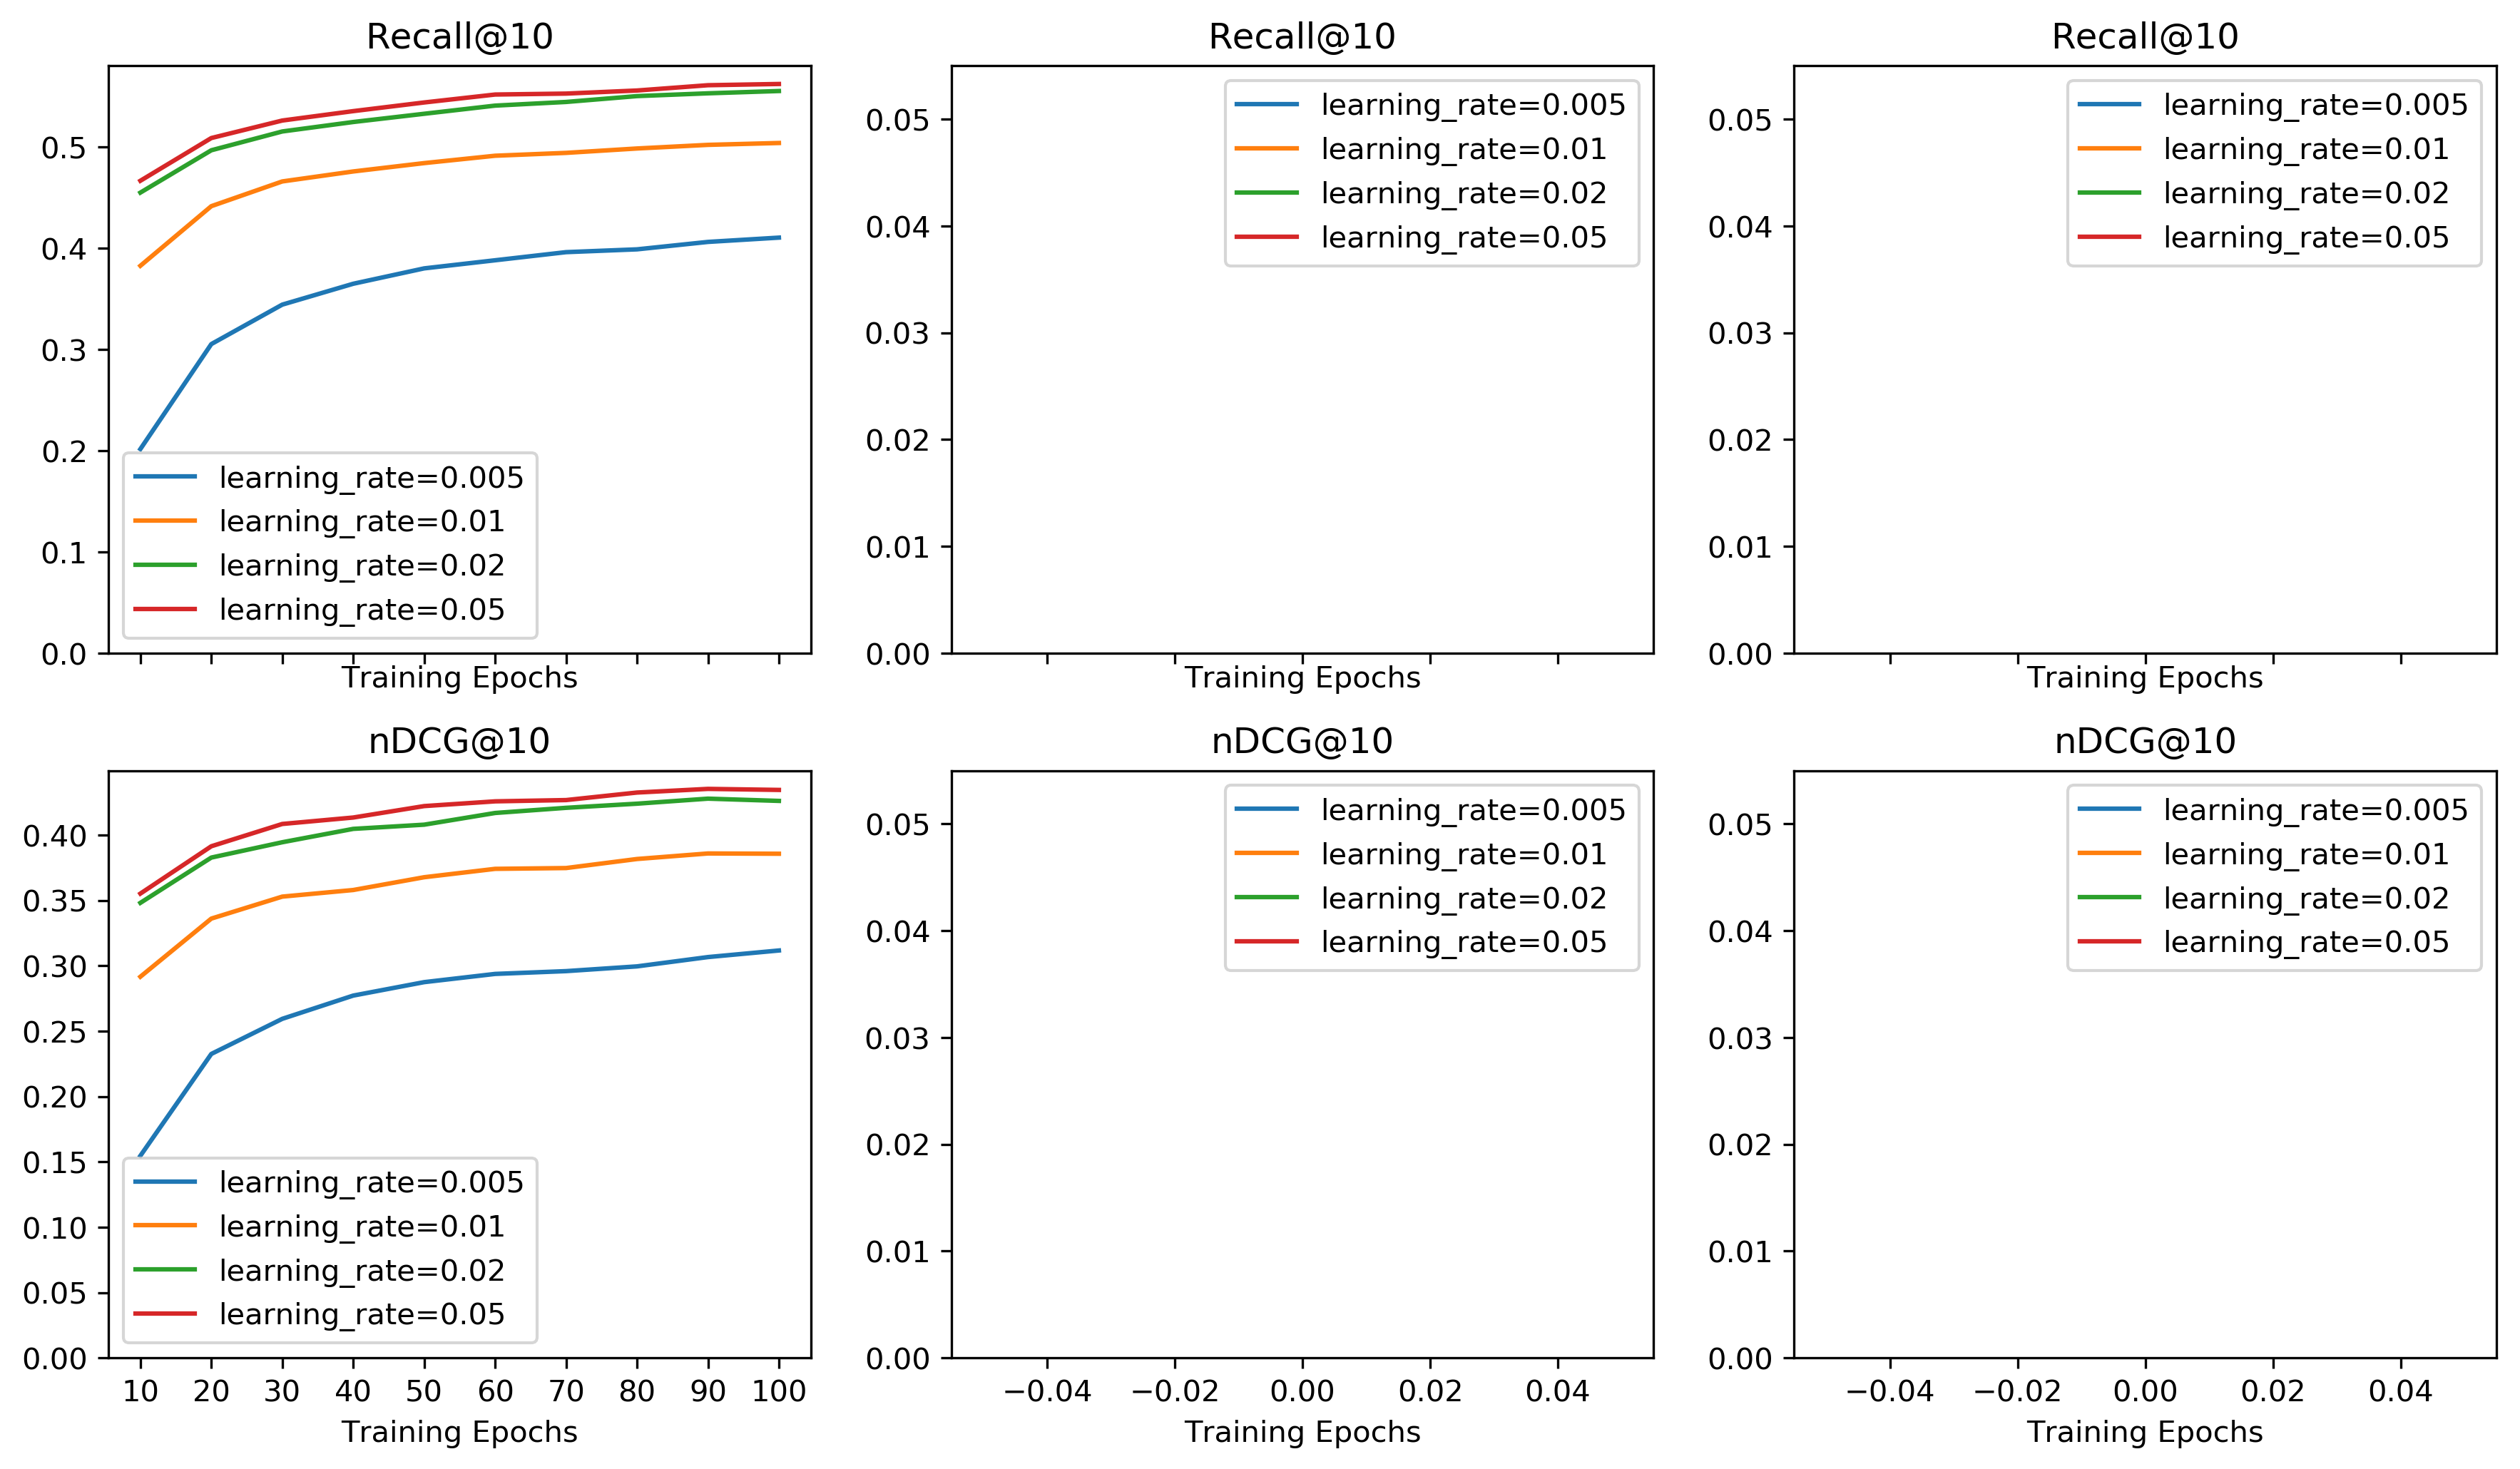

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = meetup_nfm.group_evaluations["partition"]
meetup_nfm_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = meetup_nfm_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B4096R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B4096R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
meetup_nfm_fig.show()

## Attentional Factorization Machines

### Without Pre-training

In [ ]:
meetup_afm = EvaluatePartition("../data/meetup/")

In [ ]:
import time

for f in [64, 128, 256]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "AFM/F{0}L{1}B256R001".format(f, l)
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in [str(e) for e in range(10, 100 + 1, 10)]:
                meetup_afm.add_evaluation(
                    meetup_file(os.path.join(result_dir, "AFM_F{0}L{1}B256E{2}R001.tsv".format(f, l, e))),
                    "partition", partition=e, algorithm="AFM", model_params="F{0}L{1}B256R001".format(f, l))


In [ ]:
meetup_afm.group_evaluations["partition"]

#### Ploting metrics

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = meetup_afm.group_evaluations["partition"]
meetup_afm_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = meetup_afm_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
meetup_afm_fig.show()


### With Pre-training

In [ ]:
meetup_afm_pretrained = EvaluatePartition("../data/meetup/")

In [ ]:
for f in [64]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "AFMpretrained/F{0}L{1}B256R001".format(f, l)
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in [str(e) for e in range(10, 100 + 1, 10)]:
                meetup_afm_pretrained.add_evaluation(
                    meetup_file(os.path.join(result_dir, "AFMpretrained_F{0}L{1}B256E{2}R001.tsv".format(f, l, e))),
                    "partition", partition=e, algorithm="AFMpretrained", model_params="F{0}L{1}B256R001".format(f, l))


In [ ]:
meetup_afm_pretrained.group_evaluations["partition"]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = meetup_afm_pretrained.group_evaluations["partition"]
meetup_afm_pretrained_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = meetup_afm_pretrained_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
meetup_afm_pretrained_fig.show()


# Proposed methods

## SAFMsatt with kaiming-initialzied semantics

In [46]:
meetup_safmsatt_ki_f32h128b256 = EvaluatePartition("../data/meetup/",
                                                   runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [47]:
f = 32
h = 128
for l in [str(l)[2:] for l in [0.01, 0.02]]:
    result_dir = "SAFMsatt_ki/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_ki_f32h128b256.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt_ki", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 53.19998621940613s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E10R001.tsv
-- 53.04922819137573s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E20R001.tsv
-- 53.30130386352539s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E30R001.tsv
-- 53.01692342758179s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E40R001.tsv
-- 53.25350761413574s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E50R001.tsv
-- 53.13865327835083s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E60R001.tsv
-- 53.92149901390076s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E70R001.tsv
-- 53.17379283905029s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E80R001.tsv
-- 53.26394057273865s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E90R001.tsv
-- 53.3164165019989s - SAFMsatt_ki/F32H128L01B256R001/SAFMsatt_F32H128L01B256E100R001.tsv
532.6367497444153s - SAFMsatt_ki/F32H128L01B256R001
-- 53.35990834236145s - SAFMsatt_ki/F32H128L02B2

In [48]:
meetup_safmsatt_ki_f32h128b256.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.002599      0.011922        0.004268    0.005724   45.612306   
1          0.002715      0.012842        0.004483    0.006239   48.342601   
2          0.002697      0.013198        0.004479    0.006544   47.233227   
3          0.002893      0.014413        0.004819    0.006743   45.177847   
4          0.002893      0.014413        0.004819    0.010316   45.273652   
5          0.002893      0.014413        0.004819    0.010813   42.981139   
6          0.002893      0.014413        0.004819    0.010463   42.099699   
7          0.002893      0.014413        0.004819    0.010866   41.516335   
8          0.003080      0.015707        0.005150    0.011205   42.477857   
9          0.003062      0.015467        0.005113    0.011259   46.286227   
10         0.002813      0.013912        0.004680    0.010508   44.711765   
11         0.003080      0.015575        0.005143    0.011237   44.087920   
12         0.003151      0.015831        0.005256    0.011439   44.605837   
13         0.003205      0.016435        0.005364    0.011948   43.134439   
14         0.003143      0.016173        0.005263    0.011808   43.519598   
15         0.003169      0.016442        0.005314    0.011566   47.423214   
16         0.003187      0.016358        0.005335    0.011661   48.046665   
17         0.003258      0.016861        0.005461    0.011854   48.862543   
18         0.003143      0.016015        0.005254    0.011426   48.994747   
19         0.003089      0.015640        0.005159    0.011535   45.872173   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782961              0.838636   
1             0.0              0.782961              0.838789   
2             0.0              0.782961              0.838789   
3             0.0              0.782961              0.838636   
4             0.0              0.782961              0.838636   
5             0.0              0.782961              0.838636   
6             0.0              0.782961              0.838636   
7             0.0              0.782961              0.838483   
8             0.0              0.782655              0.838330   
9             0.0              0.782196              0.838177   
10            0.0              0.782961              0.838636   
11            0.0              0.782961              0.838636   
12            0.0              0.782502              0.838483   
13            0.0              0.782502              0.838483   
14            0.0              0.782502              0.838483   
15            0.0              0.782502              0.838789   
16            0.0              0.782502              0.838789   
17            0.0              0.782502              0.838789   
18            0.0              0.782502              0.838789   
19            0.0              0.782808              0.838942   

    perc_user_events_rank_NA  partition    algorithm        model_params  
0                   0.929707         10  SAFMsatt_ki  F32H128L01B256R001  
1                   0.917786         20  SAFMsatt_ki  F32H128L01B256R001  
2                   0.911949         30  SAFMsatt_ki  F32H128L01B256R001  
3                   0.909839         40  SAFMsatt_ki  F32H128L01B256R001  
4                   0.906709         50  SAFMsatt_ki  F32H128L01B256R001  
5                   0.906780         60  SAFMsatt_ki  F32H128L01B256R001  
6                   0.906534         70  SAFMsatt_ki  F32H128L01B256R001  
7                   0.906358         80  SAFMsatt_ki  F32H128L01B256R001  
8                   0.901540         90  SAFMsatt_ki  F32H128L01B256R001  
9                   0.892257        100  SAFMsatt_ki  F32H128L01B256R001  
10                  0.916309         10  SAFMsatt_ki  F32H128L02B256R001  
11                  0.908010         20  SAFMsatt_ki  F32H128L02B256R001  
12                  0.899993         30  SAFM

## SAFMsatt with normal-initialized semantics

In [43]:
meetup_safmsatt_f32h128b256 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [44]:
f = 32
h = 128
for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
    result_dir = "SAFMsatt/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f32h128b256.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 71.5232195854187s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E10R001.tsv
-- 53.45093488693237s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E20R001.tsv
-- 53.11550569534302s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E30R001.tsv
-- 52.987478256225586s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E40R001.tsv
-- 53.046266078948975s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E50R001.tsv
-- 53.00029897689819s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E60R001.tsv
-- 53.05382227897644s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E70R001.tsv
-- 53.0443799495697s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E80R001.tsv
-- 53.08105754852295s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E90R001.tsv
-- 53.074686765670776s - SAFMsatt/F32H128L005B256R001/SAFMsatt_F32H128L005B256E100R001.tsv
549.3785319328308s - SAFMsatt/F32H128L005B256R001
-- 53.025150299072266s - SAFMsatt/F32H128L01B256R001/SAFMs

In [45]:
meetup_safmsatt_f32h128b256.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.002395      0.010207        0.003879    0.006597   45.925704   
1          0.002359      0.009914        0.003811    0.005331   44.441149   
2          0.002430      0.010398        0.003940    0.005144   45.135074   
3          0.002315      0.010027        0.003761    0.005066   46.462810   
4          0.002368      0.010163        0.003841    0.005329   46.143043   
5          0.002430      0.010564        0.003952    0.005595   44.539896   
6          0.002430      0.010430        0.003942    0.005265   43.645779   
7          0.002359      0.009996        0.003817    0.005471   46.350427   
8          0.002546      0.011365        0.004160    0.005840   47.896538   
9          0.002733      0.012728        0.004500    0.006255   46.683215   
10         0.002884      0.014308        0.004801    0.008307   42.971379   
11         0.002778      0.013259        0.004593    0.009769   45.652653   
12         0.002920      0.014166        0.004842    0.010088   43.448276   
13         0.002742      0.013577        0.004562    0.009772   42.013328   
14         0.002840      0.013868        0.004714    0.010294   43.075968   
15         0.002893      0.014398        0.004818    0.010650   41.863431   
16         0.002893      0.014413        0.004819    0.010770   44.353213   
17         0.002893      0.014413        0.004819    0.010685   46.489810   
18         0.002893      0.014413        0.004819    0.010969   48.336981   
19         0.002893      0.014413        0.004819    0.010706   47.315260   
20         0.002964      0.014763        0.004938    0.008511   45.424990   
21         0.002893      0.014413        0.004819    0.008237   46.023761   
22         0.002893      0.014413        0.004819    0.010785   45.005511   
23         0.003561      0.018925        0.005994    0.012260   45.807485   
24         0.003356      0.017558        0.005635    0.011804   45.404922   
25         0.003356      0.017558        0.005635    0.012052   43.136775   
26         0.003151      0.016093        0.005271    0.011436   46.143495   
27         0.003356      0.017558        0.005635    0.012085   48.230649   
28         0.003356      0.017558        0.005635    0.011639   45.185320   
29         0.003356      0.017558        0.005635    0.012328   47.709200   
30         0.003312      0.017032        0.005545    0.011841   41.557456   
31         0.003089      0.015567        0.005155    0.010770   47.199616   
32         0.002884      0.014287        0.004800    0.010037   43.882895   
33         0.002751      0.013449        0.004567    0.006483   44.663960   
34         0.002849      0.013502        0.004705    0.010045   44.918455   
35         0.002813      0.013727        0.004669    0.010080   47.204366   
36         0.002947      0.014361        0.004890    0.008593   47.149935   
37         0.002902      0.014705        0.004848    0.007198   46.990598   
38         0.003169      0.016312        0.005307    0.007711   47.407395   
39         0.003205      0.016339        0.005359    0.007802   45.604245   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782961              0.838789   
1             0.0              0.782961              0.838789   
2             0.0              0.782961              0.838789   
3             0.0              0.782961              0.838789   
4             0.0              0.782961              0.838789   
5             0.0              0.782961              0.838789   
6             0.0              0.782961              0.838789   
7             0.0              0.782961              0.838789   
8             0.0              0.782961              0.838636   
9             0.0              0.782961              0.838636   
10            0.0              0.782502              0.838636   
11            0.0              0.782961              0.838636   
1

# Proposed methods with different scaling

## SAFMsatt

### F16H64B256

embedding_size==semantic_num==pam_factor=16, ffn_inner_dim=64, batch_size=256

In [34]:
meetup_safmsatt_f16h64b256 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [41]:
f = 16
h = 64
for l in [str(l)[2:] for l in [0.01, 0.005]]:
    result_dir = "SAFMmp/SAFMsatt/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f16h64b256.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 52.49484300613403s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E10R001.tsv
-- 52.576351165771484s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E20R001.tsv
-- 52.50650906562805s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E30R001.tsv
-- 52.45461940765381s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E40R001.tsv
-- 52.42575645446777s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E50R001.tsv
-- 52.60903477668762s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E60R001.tsv
-- 52.55974841117859s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E70R001.tsv
-- 52.53592896461487s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E80R001.tsv
-- 52.48192286491394s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E90R001.tsv
-- 52.48222303390503s - SAFMmp/SAFMsatt/F16H64L01B256R001/SAFMsatt_F16H64L01B256E100R001.tsv
525.1281869411469s - SAFMmp/SAFMsatt/F16H64L01B256R001
-- 52.5076949596405s - 

In [42]:
meetup_safmsatt_f16h64b256.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.003454      0.016435        0.005708    0.010975   45.149224   
1          0.002893      0.014413        0.004819    0.010467   45.213667   
2          0.002893      0.014413        0.004819    0.009676   43.407305   
3          0.002893      0.014413        0.004819    0.010247   46.745879   
4          0.002893      0.014413        0.004819    0.010361   47.848094   
5          0.002893      0.014413        0.004819    0.010268   46.617002   
6          0.003258      0.015098        0.005360    0.010632   47.654067   
7          0.002920      0.014410        0.004856    0.010079   49.451004   
8          0.003303      0.015332        0.005435    0.007287   49.237996   
9          0.002920      0.014551        0.004864    0.010300   48.507524   
10         0.002964      0.014989        0.004950    0.010416   51.617982   
11         0.002893      0.014413        0.004819    0.010316   49.006421   
12         0.002893      0.014413        0.004819    0.010682   46.522888   
13         0.002893      0.014413        0.004819    0.010265   46.540019   
14         0.002893      0.014413        0.004819    0.010249   49.872525   
15         0.002893      0.014413        0.004819    0.010396   43.851297   
16         0.002893      0.014413        0.004819    0.010333   46.191772   
17         0.002893      0.014413        0.004819    0.010274   47.262693   
18         0.002893      0.014413        0.004819    0.007053   47.331965   
19         0.002893      0.014413        0.004819    0.010453   47.826249   
20         0.002217      0.009132        0.003567    0.004833   45.040535   
21         0.002217      0.009132        0.003567    0.004981   47.145646   
22         0.002466      0.011274        0.004047    0.005635   42.707383   
23         0.002893      0.014413        0.004819    0.007079   41.594451   
24         0.002893      0.014413        0.004819    0.010684   42.953430   
25         0.002893      0.014413        0.004819    0.010822   48.019106   
26         0.002893      0.014413        0.004819    0.010339   45.993202   
27         0.002893      0.014413        0.004819    0.010263   46.273346   
28         0.002893      0.014413        0.004819    0.010347   45.262577   
29         0.002947      0.014680        0.004908    0.010462   44.564725   
30         0.002056      0.007860        0.003260    0.004253   44.621176   
31         0.002190      0.008502        0.003483    0.004680   50.533050   
32         0.002510      0.011251        0.004105    0.005838   47.897944   
33         0.002306      0.009397        0.003703    0.005081   47.675301   
34         0.002662      0.011265        0.004306    0.006637   47.128649   
35         0.002386      0.010175        0.003865    0.005554   46.273684   
36         0.002599      0.009805        0.004110    0.005617   48.791045   
37         0.002653      0.009827        0.004178    0.005627   48.767348   
38         0.002893      0.010613        0.004547    0.006060   46.914550   
39         0.002813      0.010527        0.004440    0.005697   45.475433   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782502              0.838942   
1             0.0              0.782502              0.838942   
2             0.0              0.782349              0.838483   
3             0.0              0.782349              0.838636   
4             0.0              0.782349              0.838483   
5             0.0              0.782196              0.838636   
6             0.0              0.782196              0.838483   
7             0.0              0.782349              0.838483   
8             0.0              0.782196              0.838483   
9             0.0              0.782196              0.838483   
10            0.0              0.782349              0.838483   
11            0.0              0.782349              0.838483   
1

### F32H128B256
embedding_size==semantic_num==pam_factor=32, ffn_inner_dim=128, batch_size=256

In [26]:
meetup_safmsatt_f32h128b256 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [32]:
f = 32
h = 128
for l in [str(l)[2:] for l in [0.01, 0.005]]:
    result_dir = "SAFMmp/SAFMsatt/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f32h128b256.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 52.894362688064575s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E10R001.tsv
-- 52.98328638076782s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E20R001.tsv
-- 52.9061541557312s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E30R001.tsv
-- 53.06109261512756s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E40R001.tsv
-- 52.93201422691345s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E50R001.tsv
-- 53.000144481658936s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E60R001.tsv
-- 52.841933727264404s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E70R001.tsv
-- 52.608208894729614s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E80R001.tsv
-- 52.53142762184143s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E90R001.tsv
-- 52.59928512573242s - SAFMmp/SAFMsatt/F32H128L01B256R001/SAFMsatt_F32H128L01B256E100R001.tsv
528.3592185974121s - SAFMmp/SAFMsatt/F32H128L01B256R001


In [33]:
meetup_safmsatt_f32h128b256.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.003205      0.016462        0.005365    0.009642   43.056207   
1          0.001905      0.010670        0.003233    0.005452   49.641848   
2          0.001754      0.009637        0.002967    0.005559   49.914008   
3          0.002101      0.011726        0.003563    0.006849   48.872297   
4          0.003169      0.016942        0.005340    0.009154   49.650109   
5          0.003846      0.019219        0.006409    0.011585   47.665922   
6          0.004157      0.019449        0.006850    0.010786   46.420652   
7          0.004184      0.018780        0.006844    0.010461   46.255881   
8          0.004460      0.020061        0.007298    0.011197   46.510692   
9          0.005092      0.023817        0.008390    0.013064   45.737129   
10         0.003249      0.016034        0.005404    0.007786   41.431796   
11         0.004238      0.020054        0.006997    0.011588   44.349265   
12         0.006045      0.027956        0.009940    0.017428   47.267942   
13         0.007184      0.029534        0.011557    0.017043   44.841546   
14         0.008573      0.032676        0.013582    0.018854   45.450142   
15         0.007825      0.031451        0.012532    0.018069   46.233228   
16         0.008662      0.033930        0.013801    0.019563   45.978354   
17         0.009543      0.036303        0.015114    0.020833   45.555878   
18         0.008617      0.034939        0.013825    0.019631   46.724535   
19         0.008706      0.035496        0.013983    0.020381   46.030789   
20         0.002920      0.014444        0.004858    0.006823   47.786809   
21         0.003009      0.014818        0.005002    0.007060   46.229225   
22         0.003605      0.017861        0.006000    0.012356   47.729174   
23         0.003944      0.020220        0.006600    0.013217   48.829178   
24         0.004255      0.021240        0.007090    0.013238   48.323680   
25         0.004353      0.021397        0.007235    0.013429   48.013666   
26         0.005226      0.024483        0.008613    0.012958   47.423807   
27         0.006036      0.025870        0.009788    0.014923   45.620866   
28         0.006712      0.029038        0.010904    0.016588   44.046296   
29         0.007327      0.032189        0.011936    0.019862   44.144003   
30         0.002893      0.011799        0.004647    0.006293   44.775599   
31         0.003650      0.016201        0.005958    0.008275   43.609563   
32         0.003632      0.015549        0.005889    0.008197   43.809920   
33         0.003561      0.015898        0.005819    0.008461   44.675926   
34         0.003365      0.015261        0.005514    0.009005   44.777091   
35         0.003329      0.014876        0.005441    0.008892   46.375226   
36         0.003347      0.014860        0.005464    0.009111   46.966315   
37         0.003249      0.015160        0.005352    0.008505   46.835999   
38         0.003552      0.016242        0.005829    0.009051   47.341413   
39         0.003463      0.016284        0.005711    0.009677   47.478799   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782502              0.838789   
1             0.0              0.782196              0.838483   
2             0.0              0.781890              0.838330   
3             0.0              0.782349              0.838942   
4             0.0              0.783573              0.839553   
5             0.0              0.782655              0.838483   
6             0.0              0.782655              0.838330   
7             0.0              0.782655              0.838636   
8             0.0              0.782043              0.838330   
9             0.0              0.781738              0.839095   
10            0.0              0.782196              0.838330   
11            0.0              0.782502              0.838636   
1

### F64H64B4096
embedding_size==semantic_num==pam_factor=64, ffn_inner_dim=64, batch_size=4096

In [12]:
meetup_safmsatt_f64h64 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [14]:
for f in [64]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMmp/SAFMsatt/F{0}H64L{1}B4096R001".format(f, l)
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in range(10, 100 + 1, 10):
                meetup_safmsatt_f64h64.add_evaluation(
                    meetup_file(os.path.join(result_dir, "SAFMsatt_F{0}H64L{1}B4096E{2}R001.tsv".format(f, l, e))),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H64L{1}B4096R001".format(f, l))


530.8931028842926s - SAFMmp/SAFMsatt/F64H64L005B4096R001
531.1388521194458s - SAFMmp/SAFMsatt/F64H64L01B4096R001
530.8675229549408s - SAFMmp/SAFMsatt/F64H64L02B4096R001
531.0550923347473s - SAFMmp/SAFMsatt/F64H64L05B4096R001


In [15]:
meetup_safmsatt_f64h64.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.001594      0.007705        0.002641    0.003970   47.304762   
1          0.001380      0.008009        0.002354    0.004726   47.488605   
2          0.002786      0.014729        0.004686    0.009516   42.575163   
3          0.003677      0.019251        0.006174    0.012027   38.807583   
4          0.003855      0.021210        0.006524    0.013369   36.523899   
5          0.003401      0.017311        0.005685    0.011737   39.533163   
6          0.004255      0.019794        0.007005    0.012770   40.686980   
7          0.004157      0.020321        0.006903    0.012621   42.623711   
8          0.002795      0.013627        0.004639    0.009230   45.454080   
9          0.003552      0.018455        0.005957    0.010515   45.332652   
10         0.000249      0.001016        0.000400    0.000667   56.259649   
11         0.000276      0.001285        0.000454    0.000776   55.311189   
12         0.000516      0.002088        0.000828    0.001263   61.510373   
13         0.000525      0.002177        0.000846    0.001382   53.700767   
14         0.000588      0.002610        0.000959    0.001640   63.479268   
15         0.003873      0.016995        0.006308    0.008365   37.565528   
16         0.002733      0.014494        0.004599    0.009108   45.357895   
17         0.002795      0.014663        0.004695    0.010161   42.957246   
18         0.002769      0.014687        0.004659    0.009239   46.925524   
19         0.002324      0.010564        0.003809    0.006033   44.992052   
20         0.000427      0.001700        0.000683    0.000976   50.971602   
21         0.000160      0.000592        0.000252    0.000398   51.992634   
22         0.000151      0.000650        0.000246    0.000471   56.196774   
23         0.000196      0.000915        0.000323    0.000476   56.284501   
24         0.000632      0.003174        0.001054    0.001356   47.458924   
25         0.000392      0.001950        0.000652    0.000856   44.924242   
26         0.000383      0.002060        0.000646    0.000871   46.033033   
27         0.000552      0.002920        0.000928    0.001174   45.988166   
28         0.000623      0.003057        0.001035    0.001270   43.897196   
29         0.000623      0.002882        0.001025    0.001245   45.786787   
30         0.000917      0.004849        0.001542    0.003211   45.145161   
31         0.001006      0.005604        0.001706    0.002577   50.292784   
32         0.000374      0.001179        0.000568    0.000653   59.341853   
33         0.000481      0.001662        0.000746    0.000809   51.922607   
34         0.000525      0.002017        0.000833    0.001099   49.904669   
35         0.000561      0.002349        0.000906    0.001337   49.406250   
36         0.000596      0.002547        0.000967    0.001374   47.772374   
37         0.000614      0.002678        0.000999    0.001574   48.282772   
38         0.000641      0.002780        0.001042    0.001592   47.631970   
39         0.000614      0.002691        0.001000    0.001557   45.676030   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782196              0.838636   
1             0.0              0.782349              0.839095   
2             0.0              0.782196              0.839247   
3             0.0              0.782196              0.839095   
4             0.0              0.782196              0.838942   
5             0.0              0.782349              0.838789   
6             0.0              0.782349              0.838942   
7             0.0              0.782655              0.838636   
8             0.0              0.782655              0.838636   
9             0.0              0.782349              0.838942   
10            0.0              0.782808              0.839095   
11            0.0              0.782655              0.839095   
1

### F64H128B4096
embedding_size==semantic_num==pam_factor=64, ffn_inner_dim=128, batch_size=4096

In [16]:
meetup_safmsatt_f64h128 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [17]:
f = 64
for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
    result_dir = "SAFMmp/SAFMsatt/F{0}H128L{1}B4096R001".format(f, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H128L{1}B4096E{2}R001.tsv".format(f, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f64h128.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H128L{1}B4096R001".format(f, l))


-- 52.589536905288696s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E10R001.tsv
-- 52.58515286445618s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E20R001.tsv
-- 52.54674482345581s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E30R001.tsv
-- 52.582242488861084s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E40R001.tsv
-- 52.59533762931824s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E50R001.tsv
-- 52.548717975616455s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E60R001.tsv
-- 52.96890044212341s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E70R001.tsv
-- 53.01708984375s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E80R001.tsv
-- 53.1017632484436s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E90R001.tsv
-- 52.99152755737305s - SAFMmp/SAFMsatt/F64H128L005B4096R001/SAFMsatt_F64H128L005B4096E100R001.tsv
527.52814412117s - S

In [18]:
meetup_safmsatt_f64h128.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.000338      0.001046        0.000511    0.000698   54.444640   
1          0.001104      0.005630        0.001846    0.003218   44.474385   
2          0.001478      0.007704        0.002480    0.005553   45.410930   
3          0.002226      0.010777        0.003689    0.007694   50.230266   
4          0.001504      0.007762        0.002520    0.005347   49.498260   
5          0.001611      0.008116        0.002689    0.006132   49.263566   
6          0.001985      0.009374        0.003277    0.006634   47.105139   
7          0.002279      0.010696        0.003757    0.006641   46.982831   
8          0.002635      0.013114        0.004388    0.008403   47.740873   
9          0.002003      0.010190        0.003348    0.006706   51.163333   
10         0.001869      0.008677        0.003076    0.004594   41.460803   
11         0.003739      0.016033        0.006064    0.009096   35.670588   
12         0.002065      0.009811        0.003412    0.005581   47.355898   
13         0.002582      0.013577        0.004338    0.008317   51.755481   
14         0.002083      0.008253        0.003327    0.005232   50.737534   
15         0.003187      0.016937        0.005365    0.008686   46.104272   
16         0.003338      0.017920        0.005628    0.010951   48.630480   
17         0.002929      0.015350        0.004919    0.010792   47.166551   
18         0.003160      0.015940        0.005275    0.010852   45.571939   
19         0.003481      0.018238        0.005846    0.010911   47.851115   
20         0.000329      0.001480        0.000539    0.000794   50.908397   
21         0.000899      0.005105        0.001529    0.002645   49.912676   
22         0.001754      0.008512        0.002908    0.004921   50.605598   
23         0.002546      0.012683        0.004241    0.007712   46.340145   
24         0.002234      0.010076        0.003658    0.005435   46.607002   
25         0.001255      0.005990        0.002076    0.002868   49.963904   
26         0.001246      0.005040        0.001998    0.002289   49.404397   
27         0.001362      0.005581        0.002190    0.002765   47.806003   
28         0.001656      0.007290        0.002699    0.003749   46.202011   
29         0.001878      0.008488        0.003076    0.004373   46.544908   
30         0.001798      0.010227        0.003059    0.006179   47.087253   
31         0.002413      0.012125        0.004024    0.006115   46.247137   
32         0.000917      0.004007        0.001492    0.002105   53.397838   
33         0.000125      0.000446        0.000195    0.000243   54.400428   
34         0.000160      0.000549        0.000248    0.000261   51.228070   
35         0.000160      0.000560        0.000249    0.000264   49.452196   
36         0.000169      0.000653        0.000269    0.000286   48.701333   
37         0.000151      0.000564        0.000239    0.000295   48.750663   
38         0.000160      0.000538        0.000247    0.000245   50.261283   
39         0.000231      0.000912        0.000369    0.000425   47.463700   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782349              0.838942   
1             0.0              0.782961              0.839095   
2             0.0              0.782961              0.839095   
3             0.0              0.782808              0.838942   
4             0.0              0.782961              0.838942   
5             0.0              0.782961              0.838942   
6             0.0              0.782655              0.838636   
7             0.0              0.782655              0.838636   
8             0.0              0.782808              0.838636   
9             0.0              0.782808              0.838636   
10            0.0              0.782655              0.839095   
11            0.0              0.783420              0.839095   
1

### F64H256B256

In [23]:
meetup_safmsatt_f64h256b256 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [24]:
f = 64
h = 256
for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
    result_dir = "SAFMmp/SAFMsatt/F{0}H{1}L{2}B256R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f64h256b256.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 53.05687618255615s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E10R001.tsv
-- 53.03326082229614s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E20R001.tsv
-- 53.01543641090393s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E30R001.tsv
-- 53.001521825790405s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E40R001.tsv
-- 52.9169135093689s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E50R001.tsv
-- 53.08586645126343s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E60R001.tsv
-- 53.081268072128296s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E70R001.tsv
-- 53.018296003341675s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E80R001.tsv
-- 53.00128650665283s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E90R001.tsv
-- 52.97712588310242s - SAFMmp/SAFMsatt/F64H256L005B256R001/SAFMsatt_F64H256L005B256E100R001.tsv
530.1886923313141s - SAFMmp/SAFMsatt/

In [25]:
meetup_safmsatt_f64h256b256.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.003347      0.014432        0.005434    0.009974   41.797442   
1          0.003089      0.014975        0.005122    0.010546   47.406314   
2          0.002813      0.013324        0.004645    0.009736   47.404583   
3          0.002831      0.014067        0.004713    0.008899   46.132228   
4          0.002813      0.013910        0.004680    0.008720   46.113850   
5          0.002795      0.013711        0.004644    0.006935   46.796296   
6          0.002867      0.013997        0.004759    0.006932   45.248344   
7          0.002849      0.013933        0.004730    0.006951   43.997117   
8          0.002867      0.013999        0.004759    0.006987   44.633463   
9          0.002867      0.013883        0.004752    0.006913   45.361082   
10         0.001896      0.008382        0.003093    0.003913   47.364872   
11         0.002315      0.010896        0.003818    0.006228   45.174577   
12         0.003205      0.015831        0.005331    0.010020   43.317699   
13         0.003365      0.015945        0.005557    0.010382   43.428571   
14         0.003552      0.016964        0.005874    0.011012   43.677031   
15         0.003988      0.018154        0.006540    0.011961   43.283626   
16         0.004211      0.019042        0.006897    0.012677   43.694230   
17         0.004291      0.019200        0.007014    0.012975   43.362920   
18         0.004264      0.019211        0.006979    0.013357   43.923519   
19         0.004318      0.019430        0.007065    0.013176   45.308149   
20         0.000320      0.001483        0.000527    0.001057   52.724299   
21         0.000320      0.001175        0.000504    0.000686   45.491429   
22         0.000837      0.003933        0.001380    0.001891   49.846039   
23         0.002297      0.011922        0.003852    0.006415   43.942297   
24         0.002982      0.016170        0.005036    0.009148   45.353647   
25         0.003392      0.020387        0.005816    0.011572   45.263115   
26         0.003196      0.018500        0.005450    0.009874   45.589187   
27         0.004380      0.024511        0.007432    0.014055   45.323082   
28         0.005270      0.026580        0.008796    0.016160   43.791473   
29         0.005876      0.027482        0.009681    0.016882   43.030020   
30         0.000196      0.000745        0.000310    0.000417   55.315789   
31         0.000294      0.000996        0.000454    0.000548   52.278020   
32         0.000410      0.001441        0.000638    0.000727   52.261283   
33         0.000552      0.001891        0.000855    0.000923   53.720976   
34         0.000356      0.001601        0.000583    0.000730   55.136000   
35         0.000276      0.001019        0.000434    0.000525   54.303136   
36         0.000240      0.000951        0.000384    0.000489   53.239847   
37         0.000338      0.001384        0.000544    0.000645   55.744550   
38         0.000178      0.000684        0.000283    0.000396   54.922367   
39         0.000116      0.000358        0.000175    0.000277   54.270701   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782808              0.838789   
1             0.0              0.782961              0.838636   
2             0.0              0.782808              0.838636   
3             0.0              0.782961              0.838636   
4             0.0              0.782961              0.838636   
5             0.0              0.782961              0.838636   
6             0.0              0.782961              0.838636   
7             0.0              0.782961              0.838636   
8             0.0              0.782961              0.838636   
9             0.0              0.782961              0.838636   
10            0.0              0.782349              0.838177   
11            0.0              0.782349              0.838177   
1

### F64H256B4096

embedding_size==semantic_num==pam_factor=64, ffn_inner_dim=256, batch_size=4096

In [ ]:
meetup_safmsatt_f64h256 = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

In [ ]:
f = 64
h = 256
for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
    result_dir = "SAFMmp/SAFMsatt/F{0}H{1}L{2}B4096R001".format(f, h, l)
    with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(10, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B4096E{3}R001.tsv".format(f, h, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmsatt_f64h128.add_evaluation(
                    meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMsatt", model_params="F{0}H{1}L{2}B4096R001".format(f, h, l))


In [22]:
meetup_safmsatt.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0          0.000516      0.002687        0.000866    0.003147    0.001758   
1          0.000926      0.003928        0.001498    0.006729    0.003733   
2          0.000516      0.002687        0.000866    0.003147    0.001758   
3          0.000926      0.003928        0.001498    0.006729    0.003733   
4          0.002697      0.013460        0.004494    0.019260    0.012133   
5          0.003650      0.018887        0.006118    0.023630    0.015423   
6          0.003481      0.017442        0.005803    0.020396    0.013207   
7          0.003597      0.016868        0.005929    0.018286    0.012238   
8          0.003196      0.014242        0.005220    0.020069    0.011462   
9          0.002697      0.012009        0.004405    0.021719    0.011178   
10         0.002680      0.012200        0.004394    0.020880    0.011741   
11         0.002706      0.012376        0.004441    0.022672    0.012910   
12         0.002332      0.010019        0.003784    0.011134    0.007438   
13         0.002519      0.009283        0.003963    0.014357    0.008422   
14         0.002662      0.010490        0.004246    0.017142    0.010253   
15         0.002555      0.009111        0.003991    0.018000    0.010310   
16         0.002528      0.011574        0.004150    0.019204    0.010798   
17         0.002252      0.009257        0.003623    0.020543    0.012115   
18         0.002733      0.012691        0.004497    0.019505    0.011898   
19         0.002599      0.011845        0.004263    0.019501    0.012104   
20         0.002778      0.013158        0.004587    0.020018    0.012127   
21         0.002671      0.012544        0.004404    0.021060    0.011979   
22         0.001709      0.007793        0.002804    0.011396    0.006778   
23         0.002493      0.011474        0.004096    0.016873    0.010111   
24         0.001905      0.009055        0.003148    0.014406    0.008149   
25         0.001869      0.008734        0.003080    0.014289    0.007779   
26         0.002537      0.013311        0.004262    0.016962    0.011122   
27         0.002582      0.013013        0.004309    0.018387    0.011437   
28         0.002404      0.011931        0.004001    0.018137    0.010806   
29         0.002573      0.012769        0.004283    0.018986    0.011581   
30         0.002617      0.012891        0.004351    0.019801    0.011616   
31         0.002742      0.013508        0.004559    0.020443    0.012138   
32         0.001264      0.006212        0.002101    0.012348    0.007357   
33         0.000418      0.002085        0.000697    0.001883    0.000936   
34         0.000490      0.002415        0.000814    0.003528    0.001108   
35         0.000561      0.002760        0.000932    0.003438    0.001576   
36         0.000561      0.002760        0.000932    0.003714    0.001330   
37         0.000561      0.002760        0.000932    0.004719    0.002057   
38         0.000561      0.002760        0.000932    0.005307    0.003378   
39         0.000561      0.002760        0.000932    0.005481    0.002600   
40         0.000561      0.002760        0.000932    0.005633    0.002605   
41         0.000445      0.002104        0.000735    0.006145    0.002339   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
0     0.001309   0.000765   0.000650   53.775000            0.0   
1     0.001819   0.001232   0.000766   49.580400            0.0   
2     0.001309   0.000765   0.000650   53.775000            0.0   
3     0.001819   0.001232   0.000766   49.580400            0.0   
4     0.007011   0.004890   0.003616   40.643594            0.0   
5     0.011010   0.007798   0.006721   39.660611            0.0   
6     0.009651   0.006429   0.005492   46.565795            0.0   
7     0.008937   0.005848   0.004837   43.921053            0.0   
8     0.007450   0.005140   0.003979   43.421814            0.0   
9     0.006706   0.005

## SAFM ResidualConcatenation, has FeedForward
Shared-Nothing

In [39]:
meetup_safmrcsn = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [40]:
h = 256
for f in [32, 64]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMrcsn"
        with elapsed_timer("{0}s - %s" % (result_dir,)):
            for e in range(100, 100 + 1, 10):
                result_path = os.path.join(result_dir, "SAFMrcsn_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                with elapsed_timer("-- {0}s - %s" % (result_path,)):
                    meetup_safmrcsn.add_evaluation(meetup_file(result_path),
                        "partition", partition=e, algorithm="SAFMrcsn", model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 51.68357300758362s - SAFMrcsn/SAFMrcsn_F32H256L005B256E100R001.tsv
51.68365526199341s - SAFMrcsn
-- 51.45788598060608s - SAFMrcsn/SAFMrcsn_F32H256L01B256E100R001.tsv
51.45796823501587s - SAFMrcsn
-- 51.76090955734253s - SAFMrcsn/SAFMrcsn_F32H256L02B256E100R001.tsv
51.76098966598511s - SAFMrcsn
-- 51.903077363967896s - SAFMrcsn/SAFMrcsn_F32H256L05B256E100R001.tsv
51.90331029891968s - SAFMrcsn
-- 51.893046617507935s - SAFMrcsn/SAFMrcsn_F64H256L005B256E100R001.tsv
51.89328384399414s - SAFMrcsn
-- 51.93941593170166s - SAFMrcsn/SAFMrcsn_F64H256L01B256E100R001.tsv
51.93964242935181s - SAFMrcsn
-- 52.002827167510986s - SAFMrcsn/SAFMrcsn_F64H256L02B256E100R001.tsv
52.00292158126831s - SAFMrcsn
-- 51.74625492095947s - SAFMrcsn/SAFMrcsn_F64H256L05B256E100R001.tsv
51.746482372283936s - SAFMrcsn


In [41]:
meetup_safmrcsn.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0         0.002234      0.007567        0.003450    0.004499   45.245407   
1         0.001024      0.004596        0.001675    0.002515   57.914076   
2         0.006490      0.022677        0.010092    0.014651   44.975356   
3         0.000196      0.000379        0.000258    0.000369   53.462272   
4         0.000214      0.000879        0.000344    0.000430   50.915751   
5         0.000249      0.001241        0.000415    0.000639   50.685912   
6         0.001335      0.005926        0.002180    0.003387   46.616438   
7         0.003160      0.014441        0.005186    0.007913   44.529035   

   user_coverage  event_coverage_at_10  event_coverage_at_20  \
0            0.0              0.781585              0.838483   
1            0.0              0.782196              0.837871   
2            0.0              0.783267              0.837106   
3            0.0              0.781890              0.838636   
4            0.0              0.782961              0.838942   
5            0.0              0.782808              0.839247   
6            0.0              0.783114              0.839095   
7            0.0              0.782043              0.839095   

   perc_user_events_rank_NA  partition algorithm         model_params  
0                  0.946410        100  SAFMrcsn  F32H256L005B256R001  
1                  0.937795        100  SAFMrcsn   F32H256L01B256R001  
2                  0.824495        100  SAFMrcsn   F32H256L02B256R001  
3                  0.959456        100  SAFMrcsn   F32H256L05B256R001  
4                  0.990400        100  SAFMrcsn  F64H256L005B256R001  
5                  0.984774        100  SAFMrcsn   F64H256L01B256R001  
6                  0.948660        100  SAFMrcsn   F64H256L02B256R001  
7                  0.912195        100  SAFMrcsn   F64H256L05B256R001

## SAFM ResidualConcatenation, no FeedForward

In [42]:
meetup_safmrcnf = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [43]:
for f in [32, 64, 128]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMrcnf"
#         with elapsed_timer("{0}s - %s" % (result_dir,)):
        for e in range(100, 100 + 1, 10):
            result_path = os.path.join(result_dir, "SAFMrcnf_F{0}L{1}B256E{2}R001.tsv".format(f, l, e))
            with elapsed_timer("-- {0}s - %s" % (result_path,)):
                meetup_safmrcnf.add_evaluation(meetup_file(result_path),
                    "partition", partition=e, algorithm="SAFMrcnf", model_params="F{0}L{1}B256R001".format(f, l))


-- 51.565463066101074s - SAFMrcnf/SAFMrcnf_F32L005B256E100R001.tsv
-- 52.06322479248047s - SAFMrcnf/SAFMrcnf_F32L01B256E100R001.tsv
-- 53.01551914215088s - SAFMrcnf/SAFMrcnf_F32L02B256E100R001.tsv
-- 52.8263521194458s - SAFMrcnf/SAFMrcnf_F32L05B256E100R001.tsv
-- 52.90109992027283s - SAFMrcnf/SAFMrcnf_F64L005B256E100R001.tsv
-- 52.868022441864014s - SAFMrcnf/SAFMrcnf_F64L01B256E100R001.tsv
-- 52.754292249679565s - SAFMrcnf/SAFMrcnf_F64L02B256E100R001.tsv
-- 52.23741579055786s - SAFMrcnf/SAFMrcnf_F64L05B256E100R001.tsv
-- 51.539148807525635s - SAFMrcnf/SAFMrcnf_F128L005B256E100R001.tsv
-- 51.54462432861328s - SAFMrcnf/SAFMrcnf_F128L01B256E100R001.tsv
-- 51.55947709083557s - SAFMrcnf/SAFMrcnf_F128L02B256E100R001.tsv
-- 51.530508041381836s - SAFMrcnf/SAFMrcnf_F128L05B256E100R001.tsv


In [44]:
meetup_safmrcnf.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0          0.000294      0.001427        0.000487    0.000802   48.958199   
1          0.000294      0.001142        0.000467    0.000765   50.084058   
2          0.000160      0.000421        0.000232    0.000311   55.680791   
3          0.000231      0.000738        0.000352    0.000430   59.992095   
4          0.000214      0.001229        0.000364    0.000654   53.105769   
5          0.000196      0.000969        0.000326    0.000563   50.395210   
6          0.000151      0.000855        0.000257    0.000447   54.044304   
7          0.000837      0.003414        0.001344    0.001911   51.528571   
8          0.000116      0.000399        0.000179    0.000250   56.860714   
9          0.000142      0.000459        0.000217    0.000318   55.076336   
10         0.001246      0.005847        0.002055    0.004103   46.870602   
11         0.000410      0.002122        0.000687    0.001126   50.675159   

    user_coverage  event_coverage_at_10  event_coverage_at_20  \
0             0.0              0.782655              0.839095   
1             0.0              0.782961              0.838942   
2             0.0              0.782961              0.839247   
3             0.0              0.781890              0.838942   
4             0.0              0.782502              0.839095   
5             0.0              0.782808              0.838789   
6             0.0              0.782349              0.838942   
7             0.0              0.781890              0.838636   
8             0.0              0.782961              0.839095   
9             0.0              0.782196              0.838789   
10            0.0              0.782196              0.839095   
11            0.0              0.781738              0.838789   

    perc_user_events_rank_NA  partition algorithm      model_params  
0                   0.989064        100  SAFMrcnf   F32L005B256R001  
1                   0.987868        100  SAFMrcnf    F32L01B256R001  
2                   0.987552        100  SAFMrcnf    F32L02B256R001  
3                   0.982207        100  SAFMrcnf    F32L05B256R001  
4                   0.989029        100  SAFMrcnf   F64L005B256R001  
5                   0.988255        100  SAFMrcnf    F64L01B256R001  
6                   0.988888        100  SAFMrcnf    F64L02B256R001  
7                   0.970462        100  SAFMrcnf    F64L05B256R001  
8                   0.990154        100  SAFMrcnf  F128L005B256R001  
9                   0.990787        100  SAFMrcnf   F128L01B256R001  
10                  0.969020        100  SAFMrcnf   F128L02B256R001  
11                  0.983438        100  SAFMrcnf   F128L05B256R001

# Constrast methods

### Metric plot

In [16]:
import matplotlib.pyplot as plt

def plot12(dataframe):
    fig_recall_ndcg = plt.figure(figsize=[14.4, 8.0], dpi=300)
    ax_recall_ndcg = fig_recall_ndcg.subplots(nrows=3, ncols=4, sharex="col")

    for axes_i, embedding_size in enumerate([64, 128, 256]):
        for hi, hidden_size in enumerate([embedding_size * 2, embedding_size * 4]):
            ax_recall_j = hi * 2 + 0
            if axes_i == 0:
                ax_recall_ndcg[axes_i, ax_recall_j].set_title("Recall@10")
            if axes_i == 2:
                ax_recall_ndcg[axes_i, ax_recall_j].set_xlabel("Training Epochs")
            for learning_rate in [0.005, 0.01, 0.02, 0.05]:
                model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
                index = (dataframe["model_params"] == model_param)
                ax_recall_ndcg[axes_i, ax_recall_j].plot(dataframe.loc[index, "partition"],
                                                         dataframe.loc[index, "recall_at_10"],
                                                         label="lr={0}".format(str(learning_rate)))
            ax_recall_ndcg[axes_i, ax_recall_j].set_ylim(bottom=0.0)
            ax_recall_ndcg[axes_i, ax_recall_j].legend()

            ax_ndcg_j = hi * 2 + 1
            if axes_i == 0:
                ax_recall_ndcg[axes_i, ax_ndcg_j].set_title("nDCG@10")
            if axes_i == 2:
                ax_recall_ndcg[axes_i, ax_ndcg_j].set_xlabel("Training Epochs")
            for learning_rate in [0.005, 0.01, 0.02, 0.05]:
                model_param = "F{0}H{1}L{2}B256R001".format(embedding_size, hidden_size, str(learning_rate)[2:])
                index = (dataframe["model_params"] == model_param)
                ax_recall_ndcg[axes_i, ax_ndcg_j].plot(dataframe.loc[index, "partition"],
                                                       dataframe.loc[index, "ndcg_at_10"],
                                                       label="lr={0}".format(str(learning_rate)))
            ax_recall_ndcg[axes_i, ax_ndcg_j].set_ylim(bottom=0.0)
            ax_recall_ndcg[axes_i, ax_ndcg_j].legend()

    return fig_recall_ndcg

## SFMsingle

In [11]:
meetup_sfmsingle = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [30]:
for f in [256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "SFMsingle/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "SFMsingle_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        meetup_sfmsingle.add_evaluation(meetup_file(result_path),
                            "partition", partition=e, algorithm="SFMsingle",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 52.07846975326538s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E10R001.tsv
-- 52.0026593208313s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E20R001.tsv
-- 52.453381299972534s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E30R001.tsv
-- 52.22043538093567s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E40R001.tsv
-- 52.24203681945801s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E50R001.tsv
-- 52.08739924430847s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E60R001.tsv
-- 51.95325994491577s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E70R001.tsv
-- 51.86063599586487s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E80R001.tsv
-- 51.72537899017334s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E90R001.tsv
-- 52.15920042991638s - SFMsingle/F256H512L005B256R001/SFMsingle_F256H512L005B256E100R001.tsv
520.7837147712708s - SFMsingle/F256H512L005B256R001
-- 52.07270359992

In [31]:
meetup_sfmsingle.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_10  mean_ranks  \
0           0.000231      0.001308        0.000393    0.000632   50.672598   
1           0.000196      0.000963        0.000326    0.000442   52.377049   
2           0.000178      0.000870        0.000296    0.000407   50.651408   
3           0.000249      0.001528        0.000429    0.000592   54.460815   
4           0.000223      0.001406        0.000384    0.000550   55.844687   
5           0.000169      0.000855        0.000282    0.000371   52.805195   
6           0.000160      0.000919        0.000273    0.000373   44.765079   
7           0.000347      0.001954        0.000590    0.000720   47.469799   
8           0.000178      0.000675        0.000282    0.000345   53.267241   
9           0.000142      0.000704        0.000237    0.000305   54.064327   
10          0.000792      0.002529        0.001207    0.001361   51.872299   
11          0.000374      0.001627        0.000608    0.000869   53.035994   
12          0.000392      0.001756        0.000641    0.000903   50.504323   
13          0.000472      0.001330        0.000697    0.001067   48.704636   
14          0.000632      0.001413        0.000873    0.001204   48.530253   
15          0.000668      0.001498        0.000924    0.001324   52.680362   
16          0.001184      0.002503        0.001608    0.001956   51.494170   
17          0.001540      0.002459        0.001894    0.002209   52.701139   
18          0.002039      0.003366        0.002539    0.003031   50.834540   
19          0.002715      0.004157        0.003285    0.003736   49.272091   
20          0.003098      0.015080        0.005140    0.008519   46.921382   
21          0.003134      0.015599        0.005219    0.010363   46.207281   
22          0.003062      0.014971        0.005085    0.010560   48.841066   
23          0.003178      0.016206        0.005314    0.010394   48.091669   
24          0.003347      0.016901        0.005588    0.010712   46.787126   
25          0.003837      0.018715        0.006368    0.010770   45.679078   
26          0.005119      0.022978        0.008373    0.013195   44.108015   
27          0.006107      0.025584        0.009860    0.015164   42.604213   
28          0.007318      0.029701        0.011742    0.018642   42.096369   
29          0.008956      0.035472        0.014301    0.021530   41.794799   
..               ...           ...             ...         ...         ...   
210         0.000178      0.001095        0.000306    0.000678   55.537530   
211         0.000294      0.001758        0.000503    0.000886   57.195455   
212         0.000365      0.002140        0.000624    0.001080   56.147059   
213         0.000303      0.001851        0.000520    0.000929   50.946203   
214         0.000374      0.002312        0.000644    0.001045   56.395570   
215         0.000365      0.002309        0.000630    0.001021   57.035948   
216         0.000392      0.002472        0.000676    0.001010   44.858491   
217         0.000365      0.002205        0.000626    0.000902   55.131944   
218         0.000374      0.002198        0.000639    0.000878   49.049275   
219         0.000303      0.001666        0.000512    0.000704   51.156805   
220         0.001006      0.002989        0.001505    0.001644   44.120347   
221         0.001104      0.003536        0.001683    0.001809   46.943414   
222         0.001077      0.004386        0.001730    0.002003   49.640390   
223         0.000899      0.003670        0.001444    0.001696   49.264599   
224         0.000694      0.002859        0.001117    0.001312   50.329615   
225         0.000650      0.002379        0.001021    0.001156   49.362663   
226         0.000445      0.001371        0.000672    0.000762   51.662162   
227         0.000427      0.001307        0.000644    0.000702   52.318302   
228         0.000401      0.001247        0.000606    0.000647   53.544077   
229         0.000383      0

### Ploting metrics

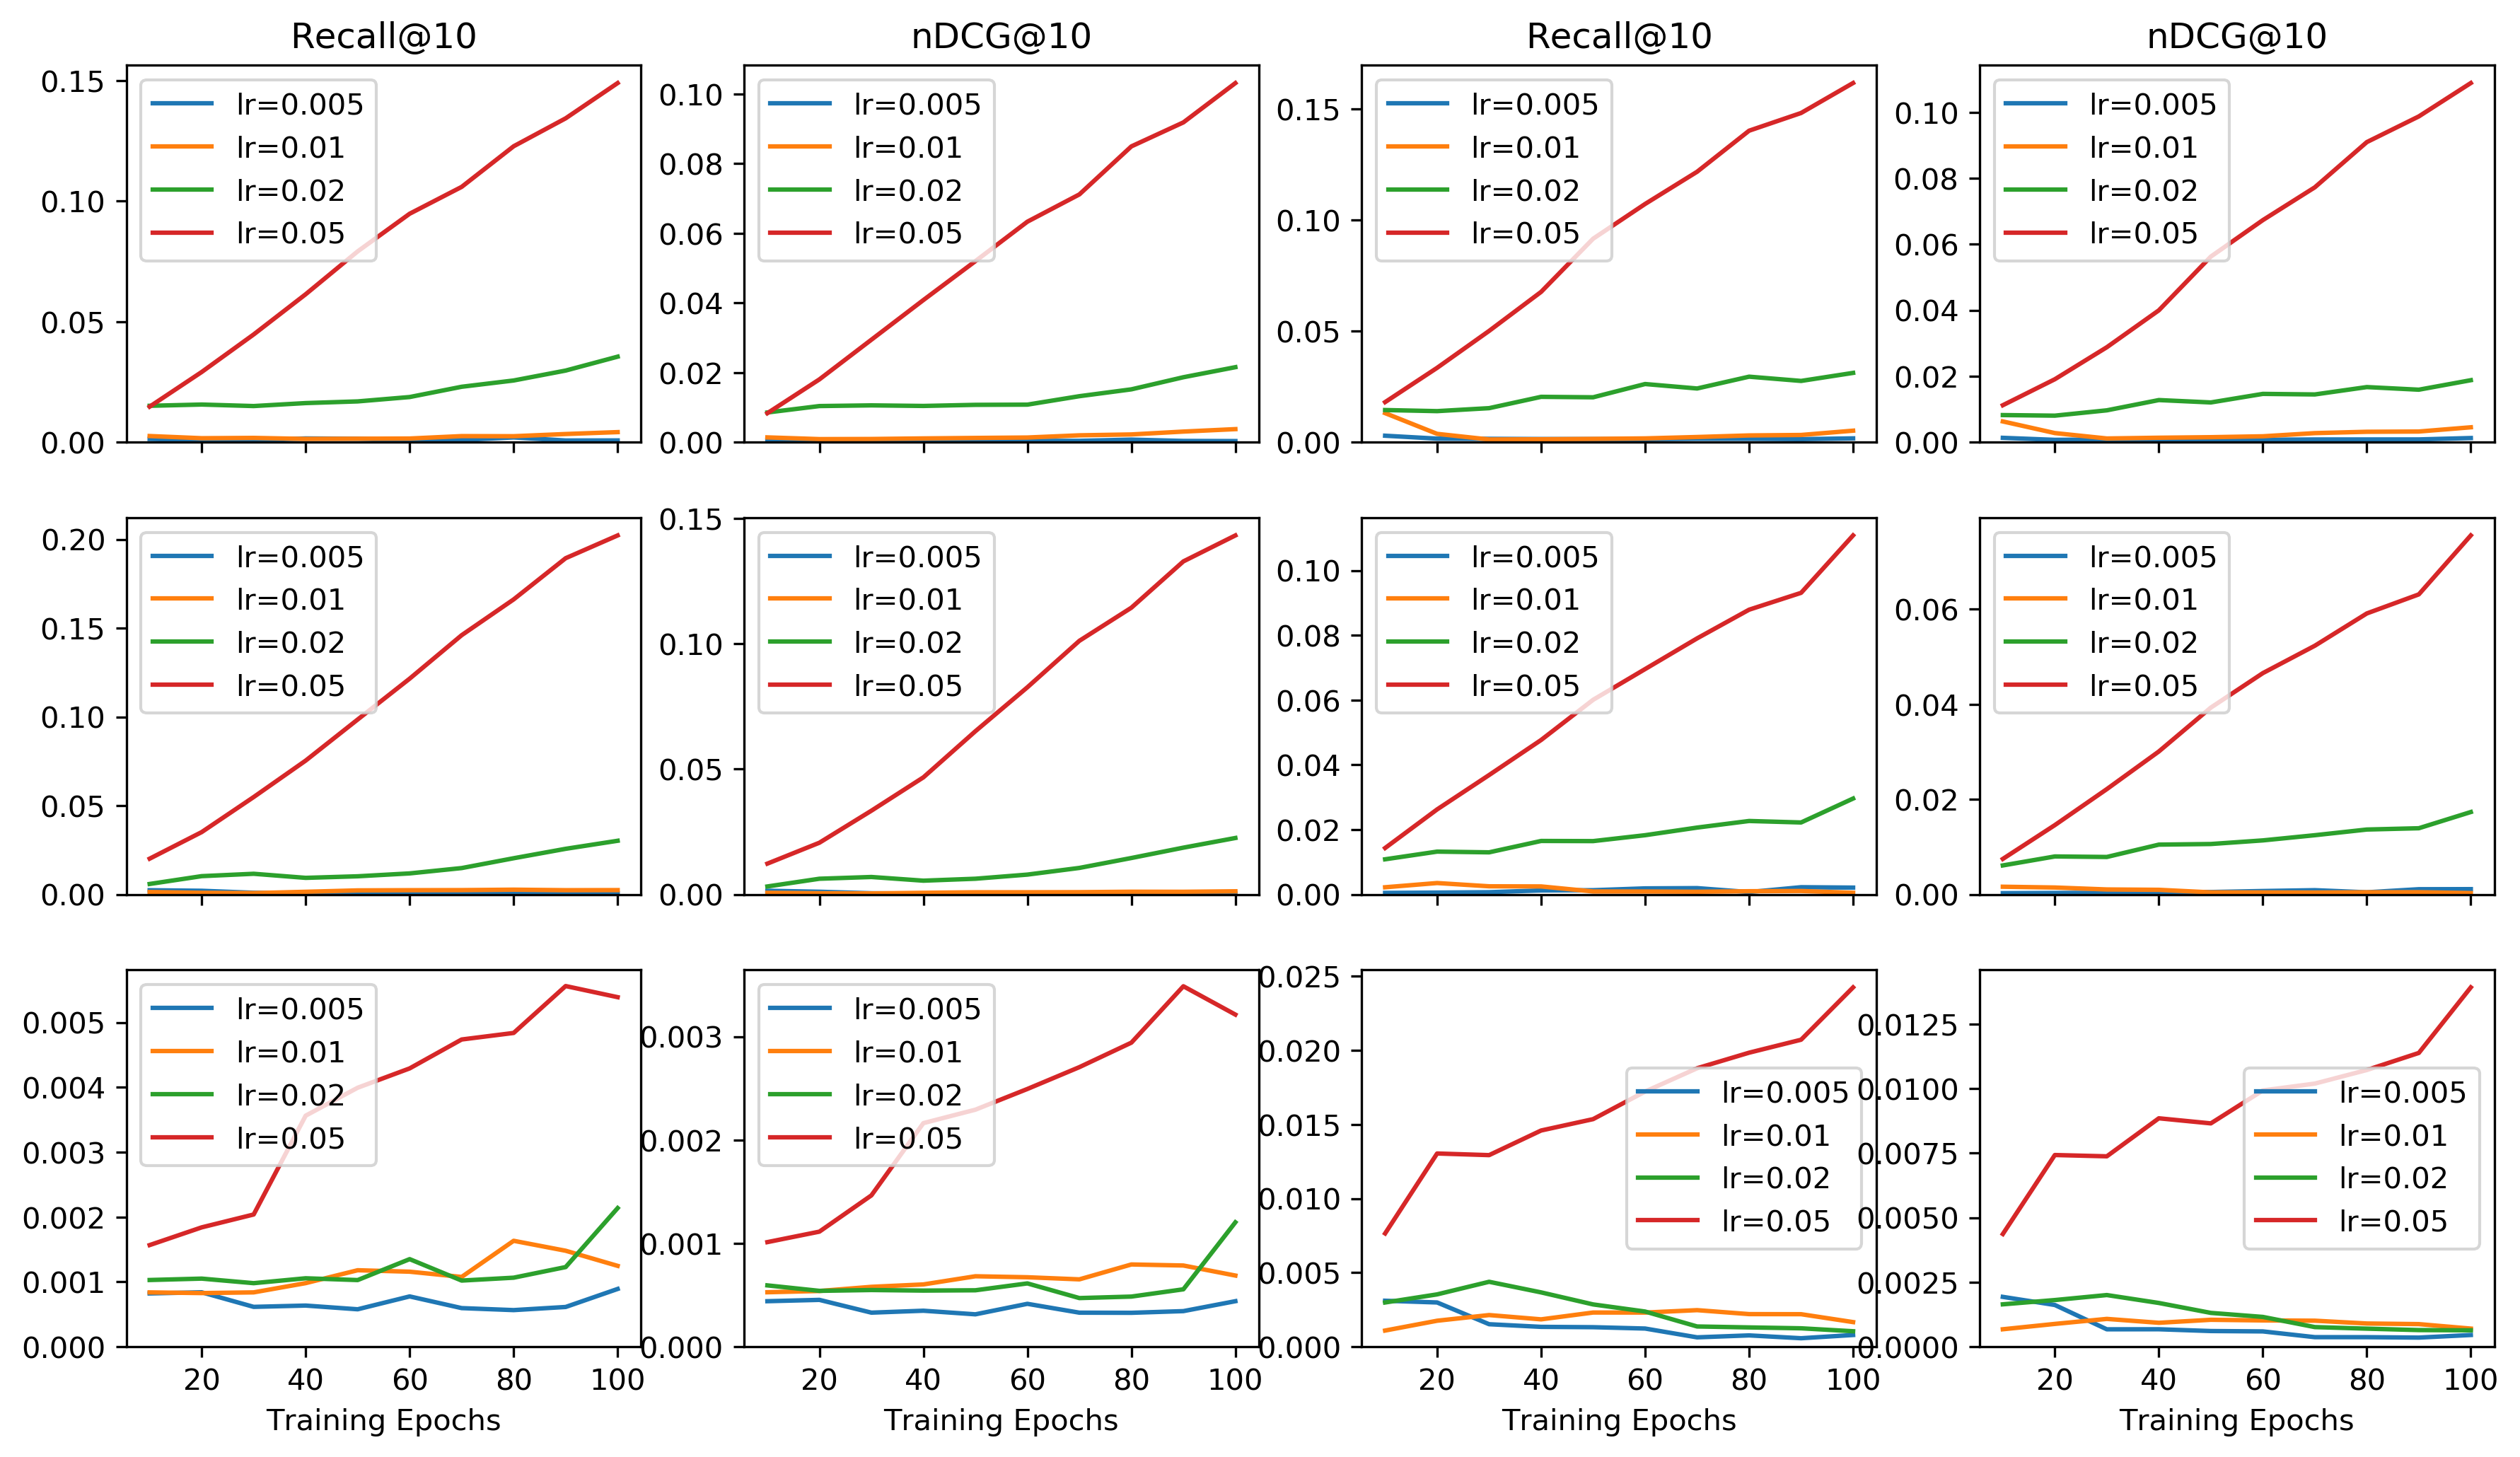

In [33]:
%matplotlib inline

plot12(meetup_sfmsingle.group_evaluations["partition"]).show()

## SFMdual

In [21]:
meetup_sfmdual = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [32]:
for f in [256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "SFMdual/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "SFMdual_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        meetup_sfmdual.add_evaluation(meetup_file(result_path),
                            "partition", partition=e, algorithm="SFMdual",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 51.17232608795166s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E10R001.tsv
-- 51.378257274627686s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E20R001.tsv
-- 51.283002853393555s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E30R001.tsv
-- 51.21180200576782s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E40R001.tsv
-- 51.537320375442505s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E50R001.tsv
-- 51.54889631271362s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E60R001.tsv
-- 51.58985733985901s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E70R001.tsv
-- 51.514039278030396s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E80R001.tsv
-- 51.945754289627075s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E90R001.tsv
-- 52.38896870613098s - SFMdual/F256H512L005B256R001/SFMdual_F256H512L005B256E100R001.tsv
515.5716633796692s - SFMdual/F256H512L005B256R001
-- 51.69774532318115s - SFMdual/F256H512L01B256R001/SF

### Ploting metrics

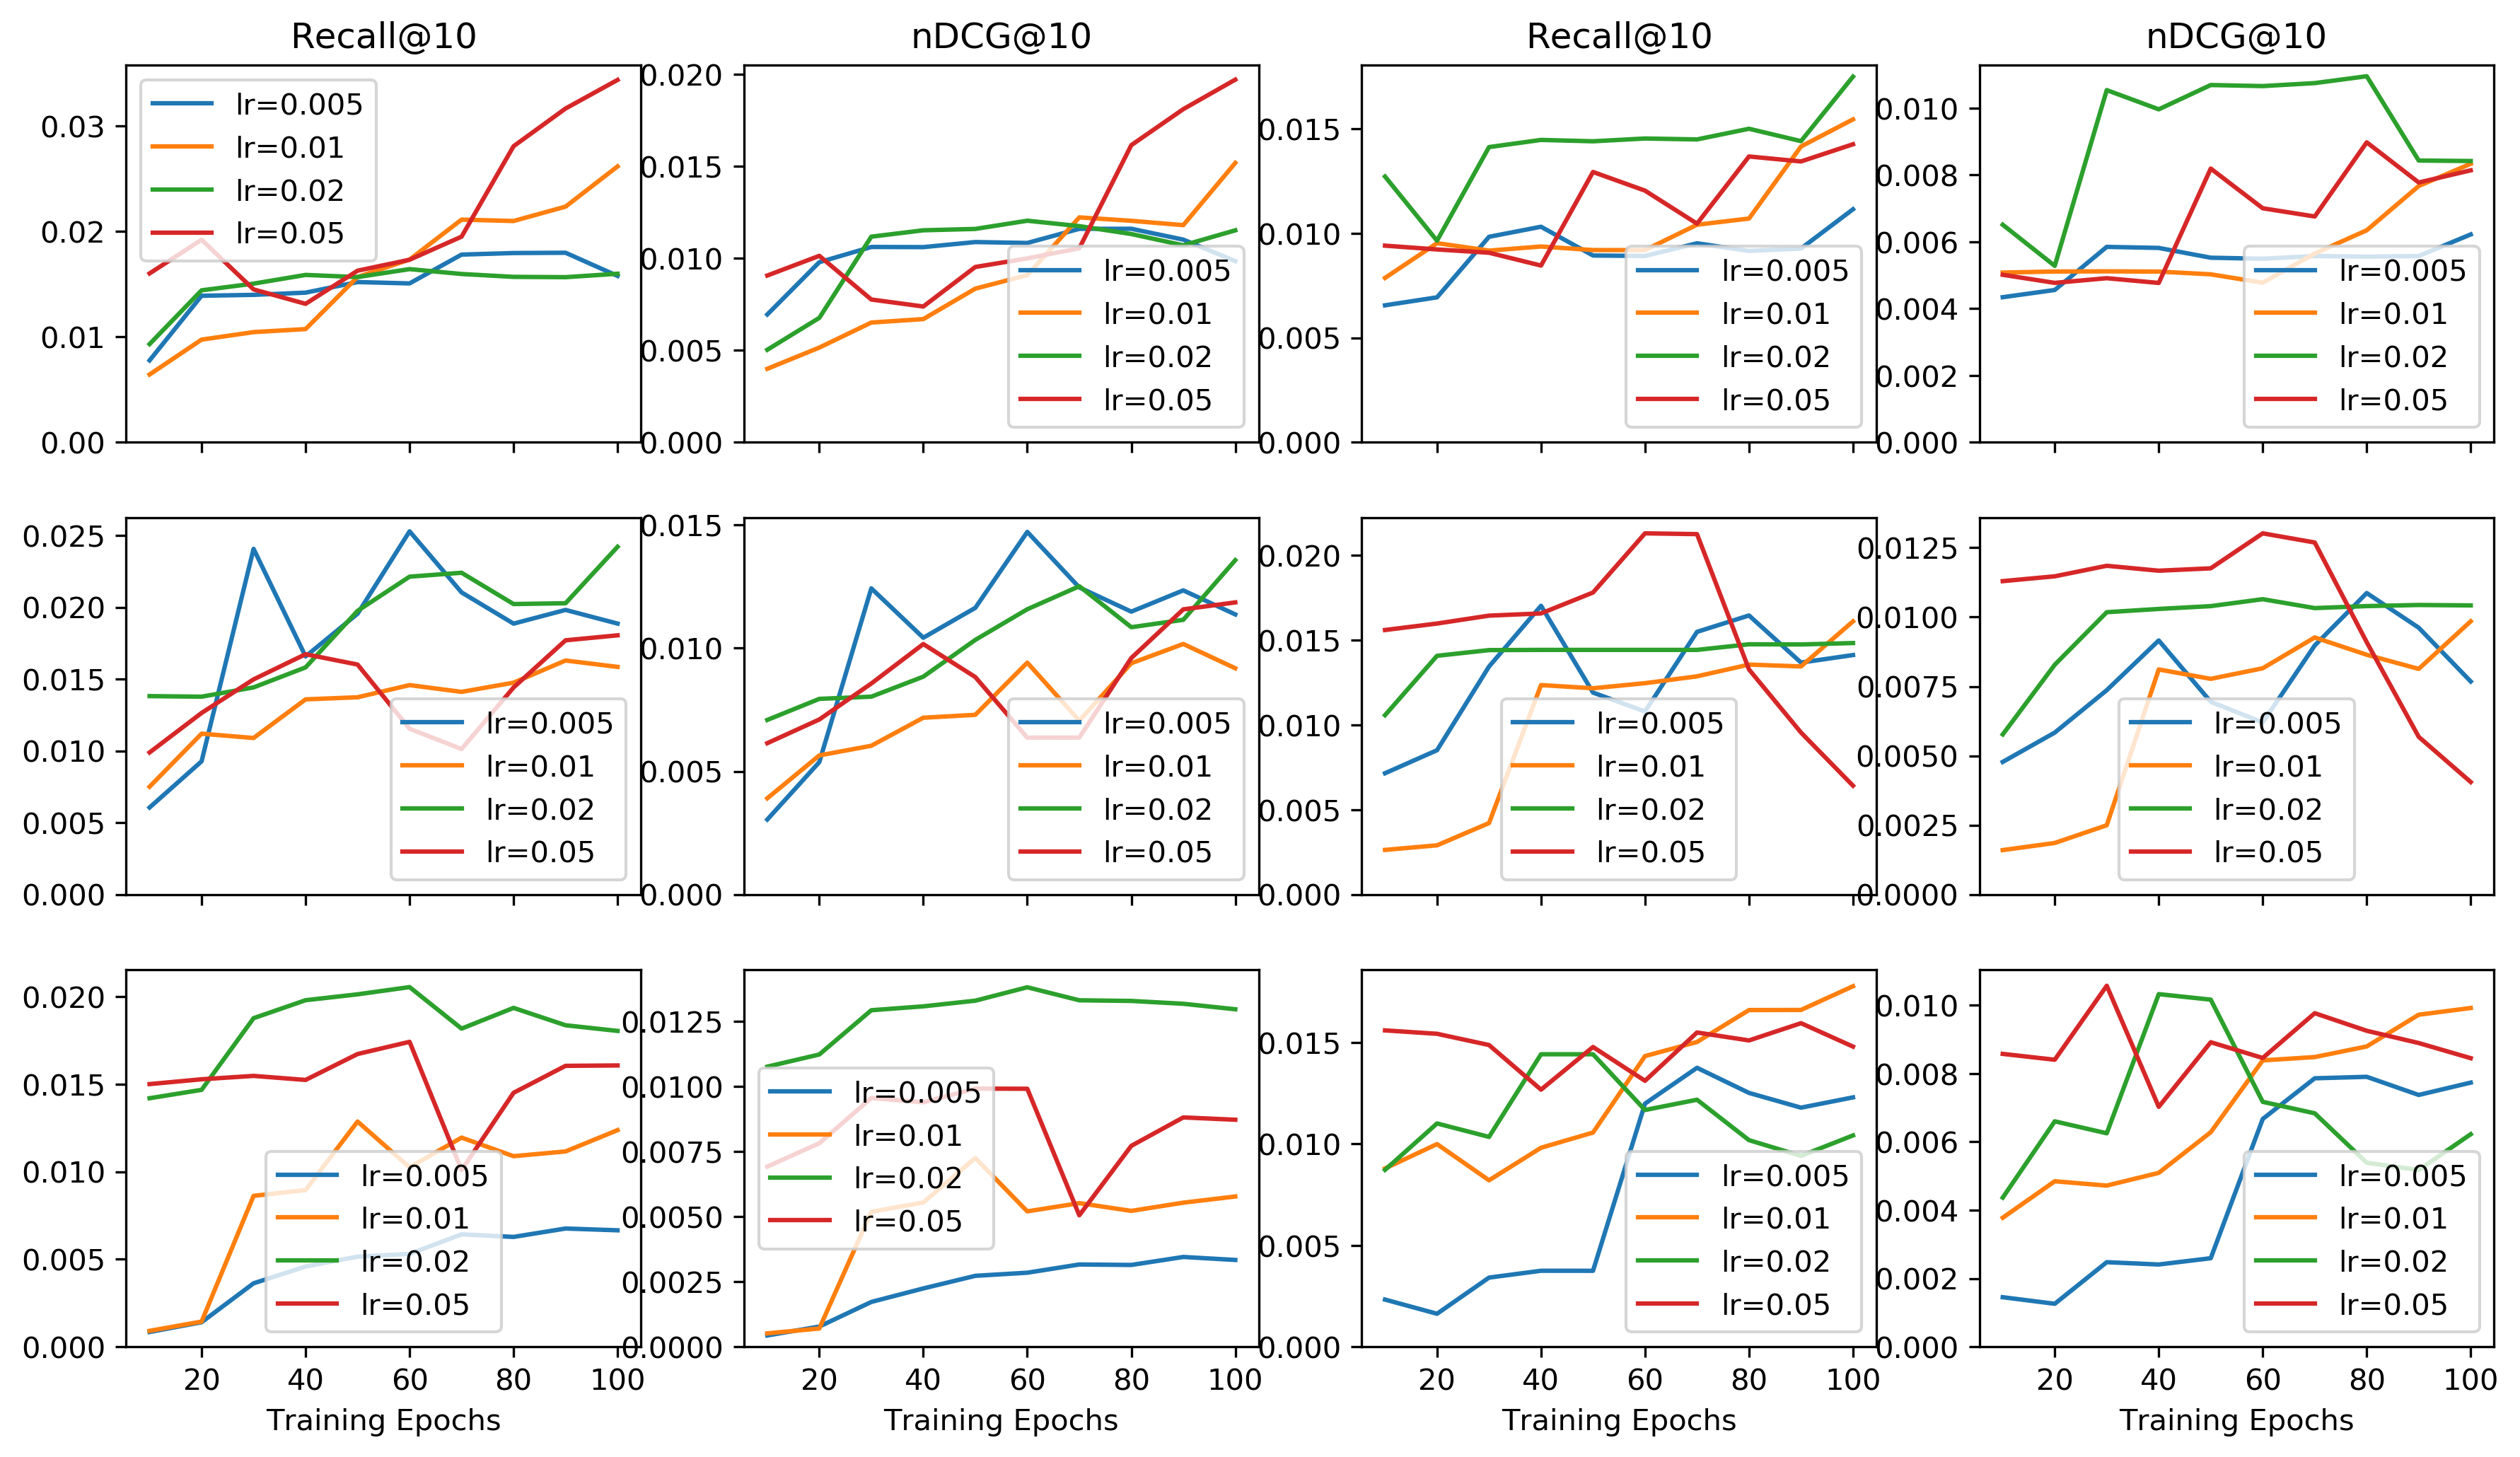

In [34]:
%matplotlib inline

plot12(meetup_sfmdual.group_evaluations["partition"]).show()

## TAFMsingle

In [24]:
meetup_tafmsingle = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [35]:
for f in [256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "TAFMsingle/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "TAFMsingle_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        meetup_tafmsingle.add_evaluation(meetup_file(result_path),
                            "partition", partition=e, algorithm="TAFMsingle",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 52.06604814529419s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E10R001.tsv
-- 52.253525495529175s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E20R001.tsv
-- 52.30409789085388s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E30R001.tsv
-- 52.18246388435364s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E40R001.tsv
-- 52.07154417037964s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E50R001.tsv
-- 52.23111033439636s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E60R001.tsv
-- 52.20069885253906s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E70R001.tsv
-- 52.41445779800415s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E80R001.tsv
-- 51.96417164802551s - TAFMsingle/F256H512L005B256R001/TAFMsingle_F256H512L005B256E100R001.tsv
521.8192739486694s - TAFMsingle/F256H512L005B256R001
-- 51.939940452575684s - TAFMsingle/F256H512L01B256R001/TAFMsingle_F256H512L01B256E10R001.

### Ploting metrics

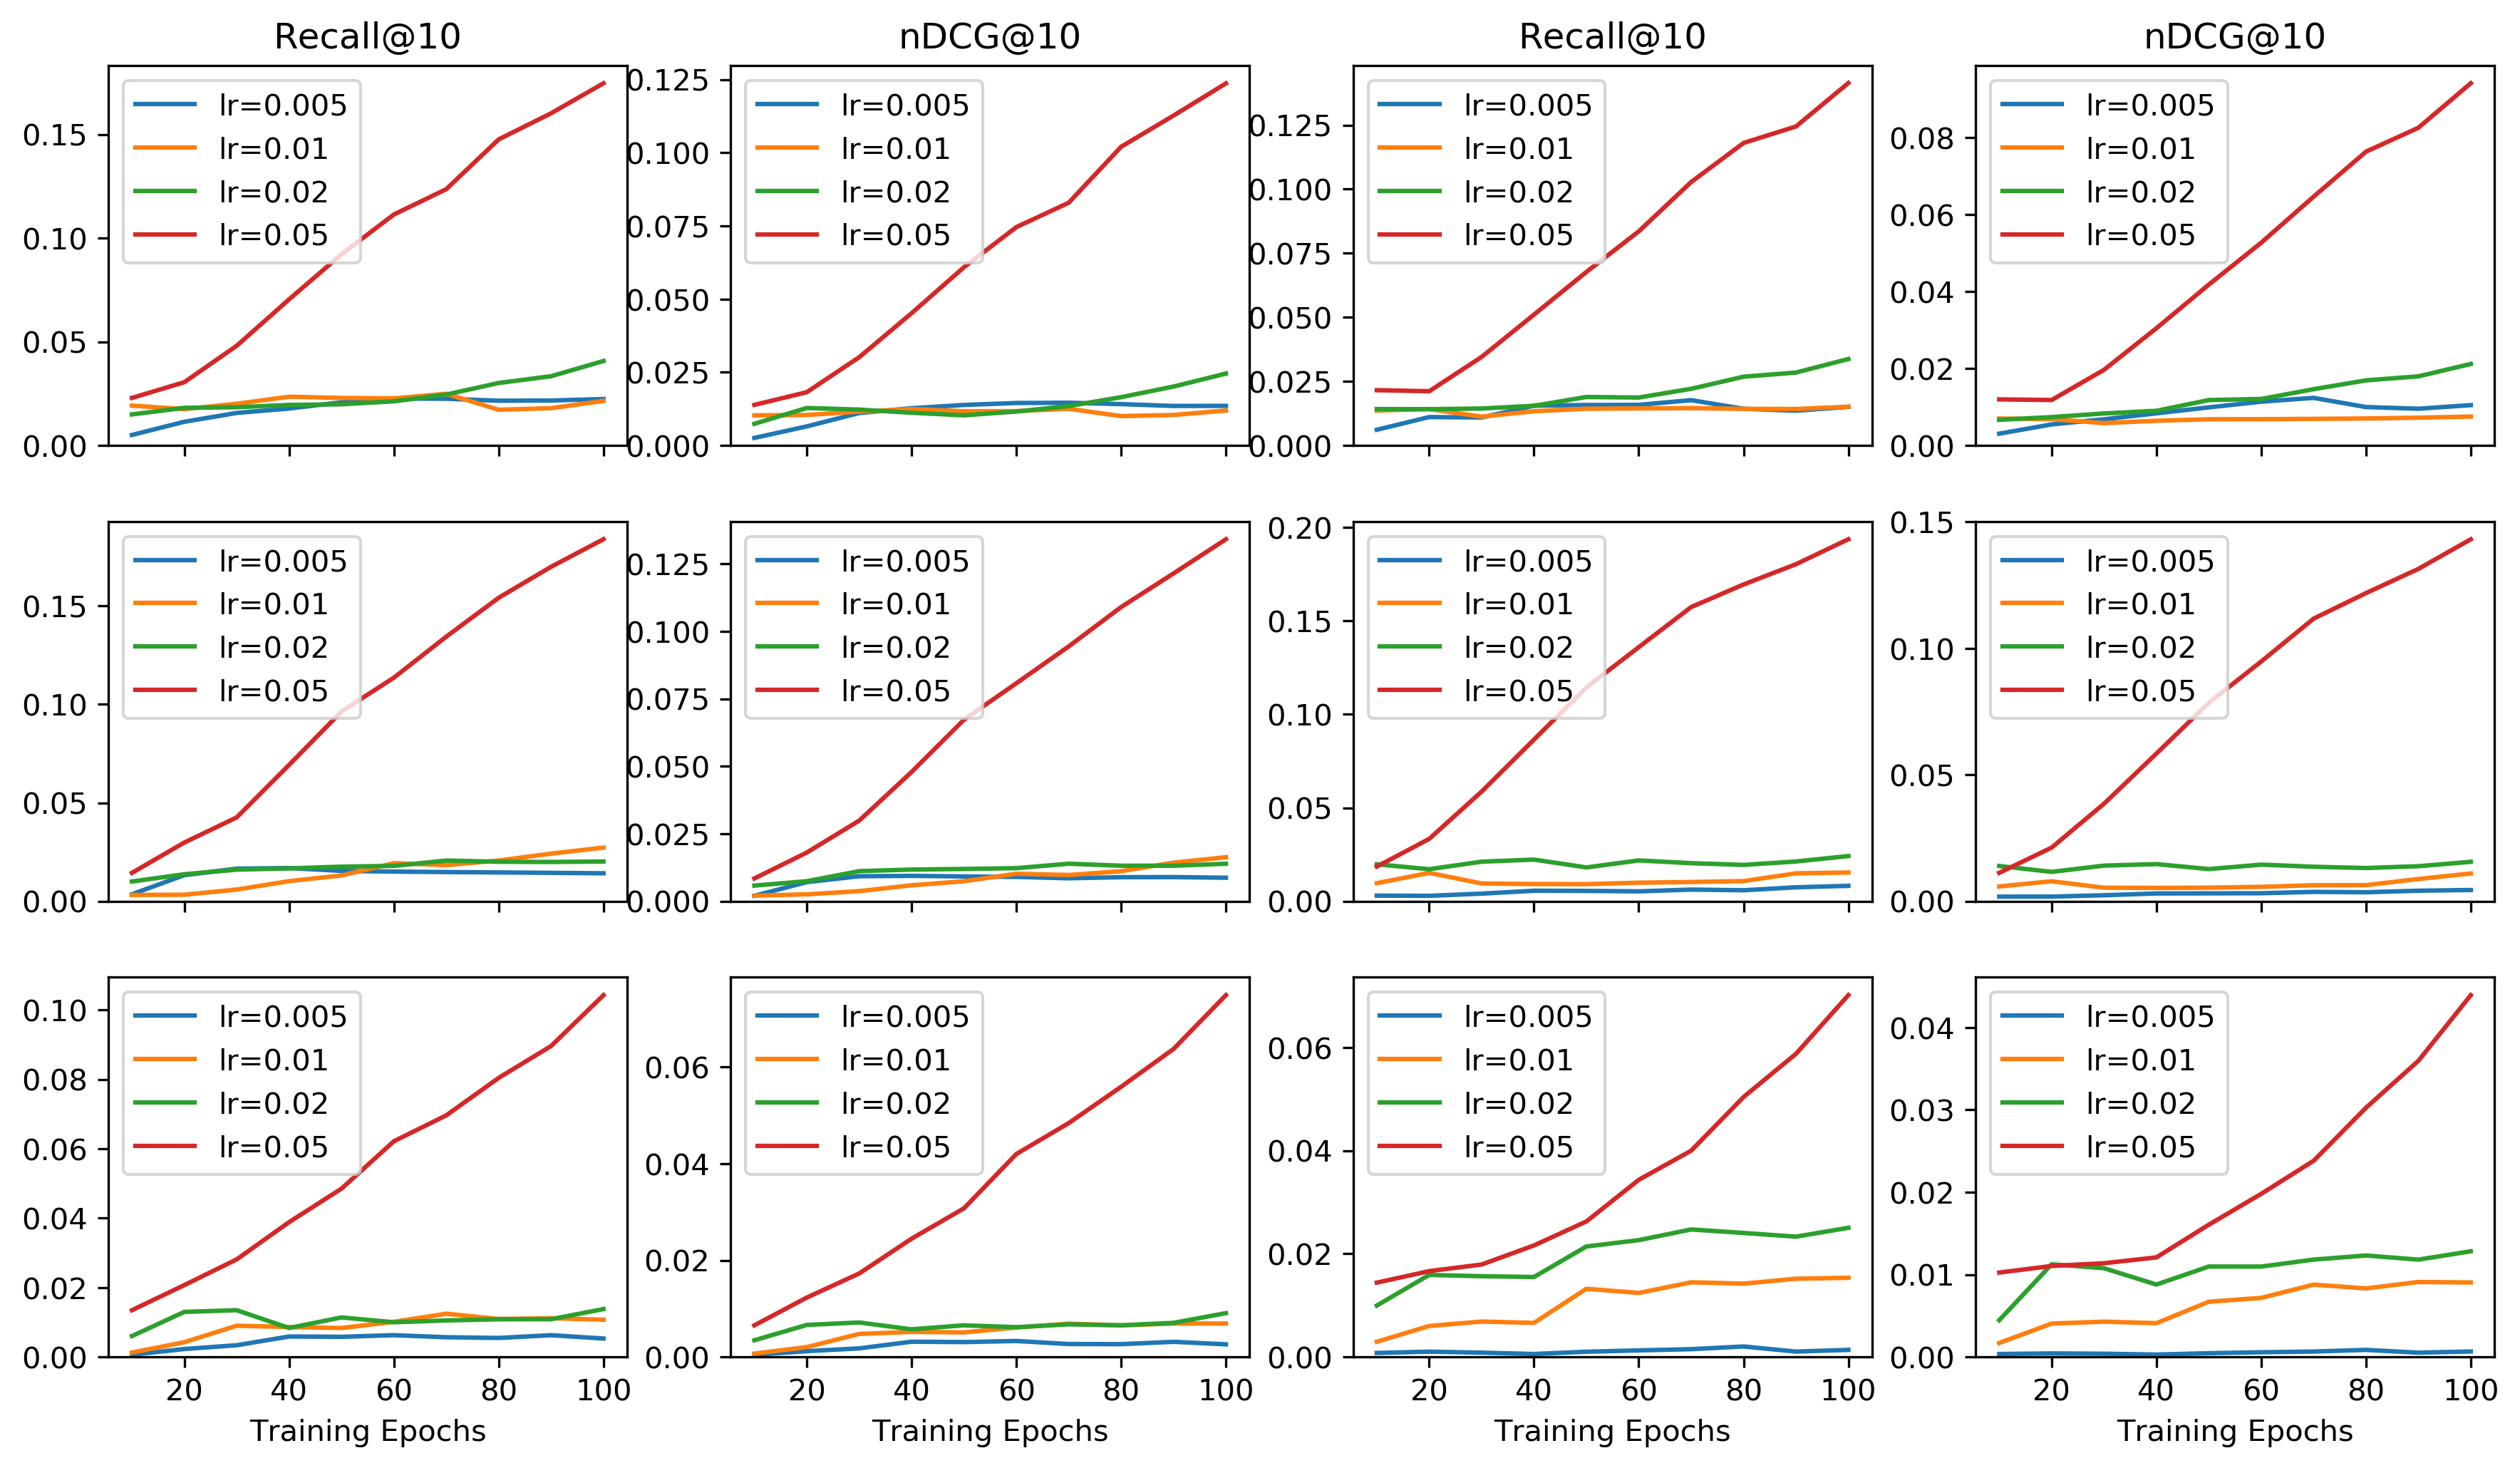

In [37]:
%matplotlib inline

plot12(meetup_tafmsingle.group_evaluations["partition"]).show()

## TAFMdual

In [27]:
meetup_tafmdual = EvaluatePartition("../data/meetup/", runMetricsPerUser=quickMetricsPerUser)

users: 11233, events: 6538


In [36]:
for f in [256]:
    for h in [f * 2, f * 4]:
        for l in [str(r)[2:] for r in [0.005, 0.01, 0.02, 0.05]]:
            result_dir = "TAFMdual/F{0}H{1}L{2}B256R001".format(f, h, l)
            with elapsed_timer("{0}s - %s" % (result_dir,)):
                for e in range(10, 100 + 1, 10):
                    result_path = os.path.join(result_dir, "TAFMdual_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
                    with elapsed_timer("-- {0}s - %s" % (result_path,)):
                        meetup_tafmdual.add_evaluation(meetup_file(result_path),
                            "partition", partition=e, algorithm="TAFMdual",
                            model_params="F{0}H{1}L{2}B256R001".format(f, h, l))


-- 52.454901456832886s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E10R001.tsv
-- 52.04806923866272s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E20R001.tsv
-- 52.26092171669006s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E30R001.tsv
-- 52.26507782936096s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E40R001.tsv
-- 52.0166757106781s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E50R001.tsv
-- 52.144012689590454s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E60R001.tsv
-- 51.9695405960083s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E70R001.tsv
-- 51.98936176300049s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E80R001.tsv
-- 52.185566902160645s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E90R001.tsv
-- 51.94305205345154s - TAFMdual/F256H512L005B256R001/TAFMdual_F256H512L005B256E100R001.tsv
521.2780783176422s - TAFMdual/F256H512L005B256R001
-- 51.90728163719177s - TAFMdual/F256

### Ploting metrics

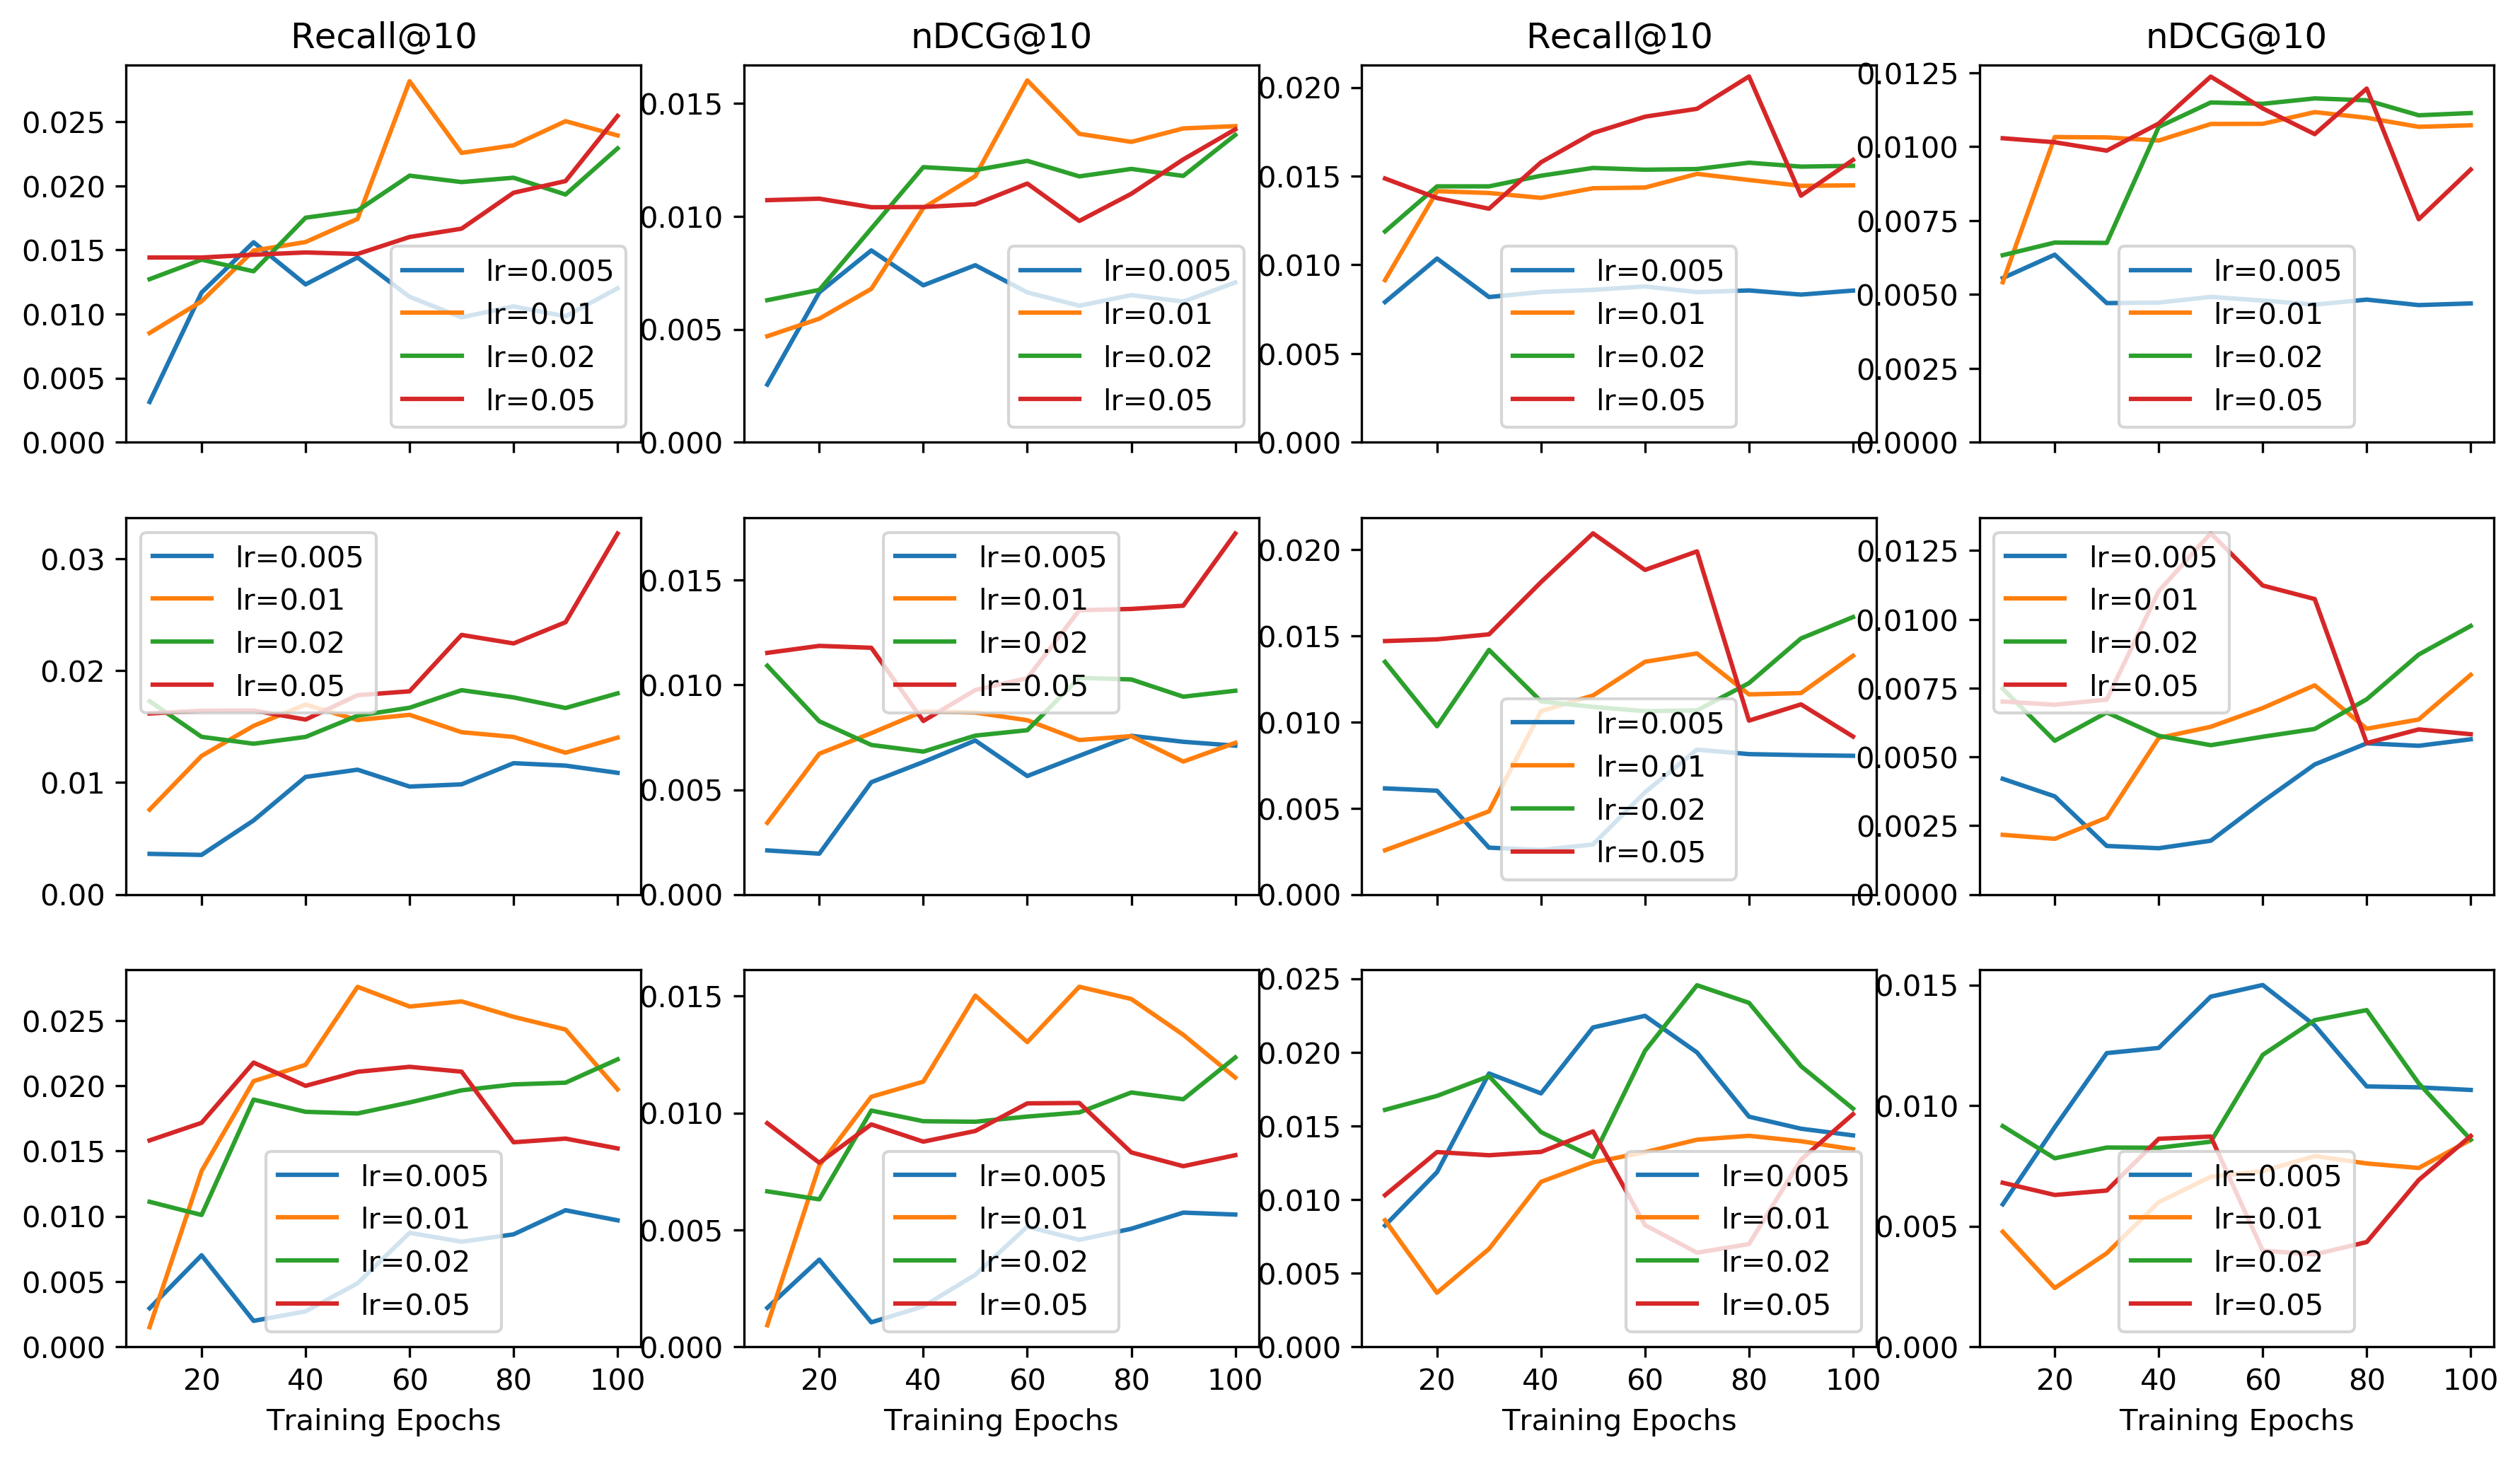

In [38]:
%matplotlib inline

plot12(meetup_tafmdual.group_evaluations["partition"]).show()

## Influence of Sharing

### Shared All

In [9]:
frappe_shared_all = EvaluatePartition("../partitioned_data/frappe/partition_1/")

users: 3387, events: 856


In [10]:
import time

for f in [64, 128, 256]:
    for l in [str(l)[2:] for l in [0.005, 0.01, 0.02, 0.05]]:
        result_dir = "SAFMsp/shared-all/F{0}L{1}B256R001".format(f, l)
        begin_time = time.time()
        for e in [str(e) for e in range(10, 100 + 1, 10)]:
            frappe_shared_all.add_evaluation(
                frappe_file(os.path.join(result_dir, "SAFMsall_F{0}H256L{1}B256E{2}R001.tsv".format(f, l, e))),
                "partition", partition=e, algorithm="SAFMsall", model_params="F{0}H256L{1}B256R001".format(f, l))
        LOGGER.critical("[%fs] Evaluated %s", time.time() - begin_time, result_dir)

[318.796216s] Evaluated SAFMsp/shared-all/F64L005B256R001
[308.200160s] Evaluated SAFMsp/shared-all/F64L01B256R001
[309.067572s] Evaluated SAFMsp/shared-all/F64L02B256R001
[310.430751s] Evaluated SAFMsp/shared-all/F64L05B256R001
[308.432753s] Evaluated SAFMsp/shared-all/F128L005B256R001
[306.660406s] Evaluated SAFMsp/shared-all/F128L01B256R001
[307.839623s] Evaluated SAFMsp/shared-all/F128L02B256R001
[308.296428s] Evaluated SAFMsp/shared-all/F128L05B256R001
[309.304761s] Evaluated SAFMsp/shared-all/F256L005B256R001
[309.175269s] Evaluated SAFMsp/shared-all/F256L01B256R001
[312.690472s] Evaluated SAFMsp/shared-all/F256L02B256R001
[328.227807s] Evaluated SAFMsp/shared-all/F256L05B256R001


In [11]:
frappe_shared_all.group_evaluations["partition"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
0           0.000738      0.007381        0.001342    0.011891    0.005643   
1           0.000561      0.005610        0.001020    0.010445    0.004703   
2           0.000443      0.004429        0.000805    0.006184    0.003283   
3           0.000384      0.003838        0.000698    0.006851    0.002884   
4           0.000413      0.004133        0.000752    0.006571    0.003719   
5           0.000325      0.003248        0.000590    0.005020    0.002748   
6           0.000266      0.002657        0.000483    0.004590    0.001679   
7           0.000413      0.004133        0.000752    0.005575    0.003041   
8           0.000384      0.003838        0.000698    0.004695    0.002938   
9           0.000266      0.002657        0.000483    0.004326    0.001684   
10          0.000856      0.008562        0.001557    0.012671    0.006175   
11          0.000709      0.007086        0.001288    0.011137    0.005020   
12          0.000561      0.005610        0.001020    0.011040    0.005225   
13          0.000531      0.005314        0.000966    0.010663    0.004274   
14          0.000472      0.004724        0.000859    0.011426    0.004363   
15          0.000679      0.006791        0.001235    0.011428    0.004728   
16          0.000266      0.002657        0.000483    0.009979    0.003150   
17          0.000354      0.003543        0.000644    0.008146    0.002836   
18          0.000177      0.001771        0.000322    0.007685    0.002333   
19          0.000354      0.003543        0.000644    0.008624    0.002757   
20          0.000502      0.005019        0.000913    0.010066    0.004981   
21          0.000472      0.004724        0.000859    0.007589    0.003554   
22          0.000590      0.005905        0.001074    0.011029    0.004356   
23          0.000945      0.009448        0.001718    0.022028    0.007244   
24          0.000974      0.009743        0.001771    0.019977    0.007737   
25          0.000590      0.005905        0.001074    0.010331    0.004713   
26          0.001122      0.011219        0.002040    0.017709    0.008886   
27          0.001063      0.010629        0.001933    0.017001    0.007777   
28          0.000886      0.008857        0.001610    0.015601    0.007290   
29          0.000620      0.006200        0.001127    0.012397    0.004868   
..               ...           ...             ...         ...         ...   
90          0.003041      0.030410        0.005529    0.069860    0.024155   
91          0.001063      0.010629        0.001933    0.024142    0.006422   
92          0.001211      0.012105        0.002201    0.024224    0.006535   
93          0.001329      0.013286        0.002416    0.016923    0.010794   
94          0.001122      0.011219        0.002040    0.033843    0.008415   
95          0.001890      0.018896        0.003436    0.039327    0.013501   
96          0.001151      0.011515        0.002094    0.020148    0.006637   
97          0.001447      0.014467        0.002630    0.030243    0.010240   
98          0.000827      0.008267        0.001503    0.012094    0.005092   
99          0.001299      0.012991        0.002362    0.031832    0.009720   
100         0.000827      0.008267        0.001503    0.035970    0.007798   
101         0.003248      0.032477        0.005905    0.051166    0.027986   
102         0.001092      0.010924        0.001986    0.028432    0.008609   
103         0.000945      0.009448        0.001718    0.022325    0.006616   
104         0.000650      0.006495        0.001181    0.010961    0.004544   
105         0.000620      0.006200        0.001127    0.009711    0.004549   
106         0.000443      0.004429        0.000805    0.010230    0.004627   
107         0.000650      0.006495        0.001181    0.011277    0.004899   
108         0.000590      0.005905        0.001074    0.012497    0.005870   
109         0.000679      0

In [13]:
dataframe = frappe_shared_all.group_evaluations["partition"]
dataframe[dataframe["model_params"] == "F64H256L05B256R001"]

precision_at_10  recall_at_10  f1_score_at_10  ndcg_at_50  ndcg_at_20  \
30         0.003602      0.036020        0.006549    0.034539    0.021900   
31         0.001181      0.011810        0.002147    0.017353    0.009841   
32         0.002244      0.022439        0.004080    0.036012    0.017246   
33         0.009271      0.092707        0.016856    0.068594    0.051419   
34         0.004222      0.042220        0.007676    0.031842    0.022460   
35         0.005019      0.050192        0.009126    0.044882    0.030465   
36         0.002657      0.026572        0.004831    0.031424    0.018445   
37         0.001004      0.010038        0.001825    0.014475    0.007350   
38         0.001329      0.013286        0.002416    0.017273    0.009214   
39         0.001919      0.019191        0.003489    0.022496    0.012842   

    ndcg_at_10  map_at_20  map_at_10  mean_ranks  user_coverage  \
30    0.015650   0.011379   0.009636   45.753989            0.0   
31    0.004729   0.004024   0.002640   52.953096            0.0   
32    0.009644   0.007951   0.005907   46.752941            0.0   
33    0.042090   0.029508   0.026986   38.138326            0.0   
34    0.017661   0.011763   0.010436   41.807882            0.0   
35    0.024635   0.018482   0.016915   44.762655            0.0   
36    0.013366   0.010849   0.009454   50.873275            0.0   
37    0.004255   0.003377   0.002547   52.029851            0.0   
38    0.006140   0.004821   0.004008   53.194332            0.0   
39    0.008098   0.006090   0.004804   49.949410            0.0   

    event_coverage_at_10  event_coverage_at_20  perc_user_events_rank_NA  \
30                   1.0                   1.0                  0.777975   
31                   1.0                   1.0                  0.842634   
32                   1.0                   1.0                  0.749040   
33                   1.0                   1.0                  0.664895   
34                   1.0                   1.0                  0.820195   
35                   1.0                   1.0                  0.737526   
36                   1.0                   1.0                  0.764689   
37                   1.0                   1.0                  0.881311   
38                   1.0                   1.0                  0.854148   
39                   1.0                   1.0                  0.824919   

   partition algorithm        model_params  
30        10  SAFMsall  F64H256L05B256R001  
31        20  SAFMsall  F64H256L05B256R001  
32        30  SAFMsall  F64H256L05B256R001  
33        40  SAFMsall  F64H256L05B256R001  
34        50  SAFMsall  F64H256L05B256R001  
35        60  SAFMsall  F64H256L05B256R001  
36        70  SAFMsall  F64H256L05B256R001  
37        80  SAFMsall  F64H256L05B256R001  
38        90  SAFMsall  F64H256L05B256R001  
39       100  SAFMsall  F64H256L05B256R001

#### Ploting metrics

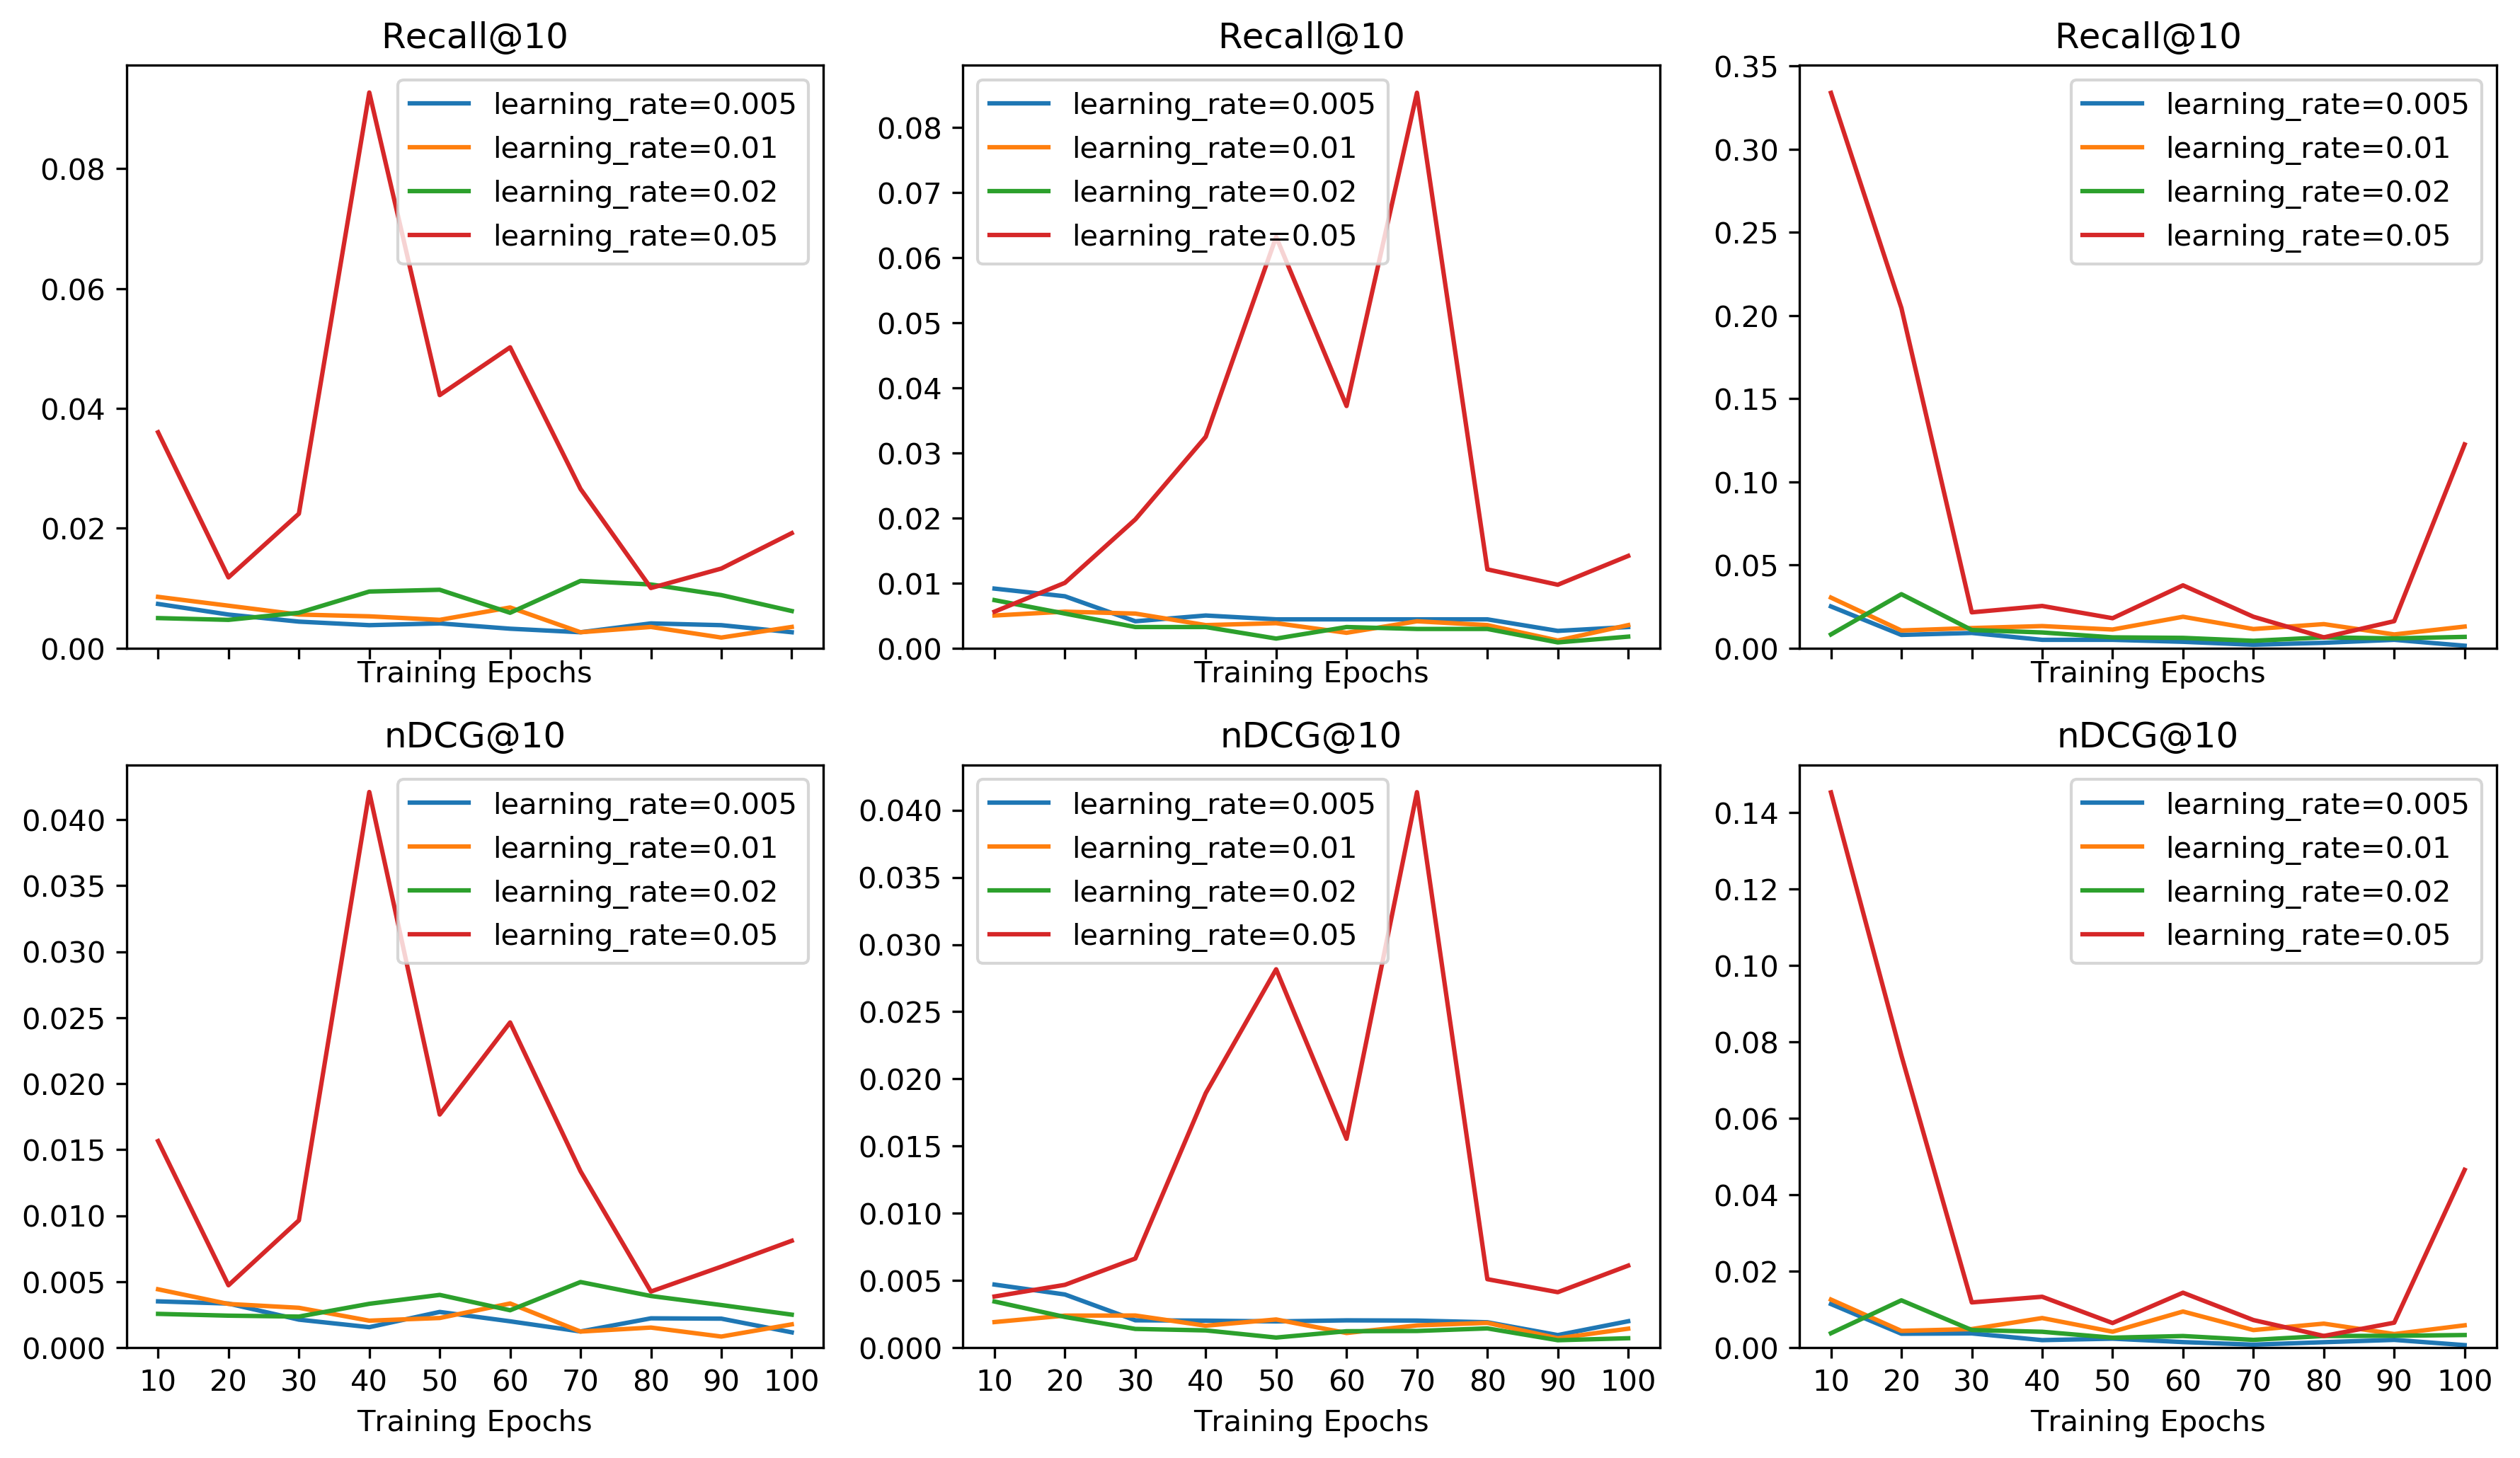

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

dataframe = frappe_shared_all.group_evaluations["partition"]
frappe_shared_all_fig = plt.figure(figsize=[14.4, 8.0], dpi=300)
ax_recall_ndcg = frappe_shared_all_fig.subplots(nrows=2, ncols=3, sharex="col")

for axes_j, embedding_size in enumerate([64, 128, 256]):
    ax_recall_ndcg[0, axes_j].set_title("Recall@10")
    ax_recall_ndcg[0, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[0, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "recall_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[0, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[0, axes_j].legend()

    ax_recall_ndcg[1, axes_j].set_title("nDCG@10")
    ax_recall_ndcg[1, axes_j].set_xlabel("Training Epochs")
    for learning_rate in [0.005, 0.01, 0.02, 0.05]:
        index = dataframe["model_params"] == "F{0}H256L{1}B256R001".format(embedding_size, str(learning_rate)[2:])
        ax_recall_ndcg[1, axes_j].plot(dataframe.loc[index, "partition"],
                                       dataframe.loc[index, "ndcg_at_10"],
                                       label="learning_rate={0}".format(str(learning_rate)))
    ax_recall_ndcg[1, axes_j].set_ylim(bottom=0.0)
    ax_recall_ndcg[1, axes_j].legend()
    
frappe_shared_all_fig.show()